#Proyecto Stats

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
!pwd

Mounted at /content/gdrive
/content


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

%cd "/content/gdrive/MyDrive/Colab Notebooks/Modulo 1"
data = pd.read_csv("dataus2024.csv")
data.shape

/content/gdrive/MyDrive/Colab Notebooks/Modulo 1


(557181, 24)

In [ ]:
firms = pd.read_csv("firmsus2024.csv")
firms.shape

(5689, 7)

In [ ]:
firms1 = firms[["empresa", "Nombre", "status", "naics1"]]
firms1.columns = ["firm", "Empresa", "Status", "Industria"]

data= pd.merge(data, firms1, on='firm', how='left')

In [ ]:
data.head()

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,originalprice,sharesoutstanding,year,fixedassets,yearf,cto,fiscalq,Empresa,Status,Industria
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104.0000,452000.000,2000,NaN,NaN,1,NaN,"Agilent Technologies, Inc",activo,Industrias manufactureras
1,A,2000q2,6.0,4731000.0,2421000.0,1925000.0,73000.0,0.0,0.0,161000.0,...,73.7500,452271.967,2000,1453000.0,2000.0,2,2.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
2,A,2000q3,9.0,7401000.0,3790000.0,3016000.0,101000.0,0.0,0.0,244000.0,...,48.9375,453014.579,2000,1581000.0,2000.0,3,3.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
3,A,2000q4,12.0,10773000.0,5522000.0,4198000.0,111000.0,0.0,0.0,407000.0,...,54.7500,456366.381,2000,1741000.0,2000.0,4,4.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
4,A,2001q1,3.0,2841000.0,1449000.0,1113000.0,19000.0,-25000.0,0.0,119000.0,...,30.7300,456769.737,2001,1821000.0,2001.0,1,1.0,"Agilent Technologies, Inc",activo,Industrias manufactureras


#Calculo la columna de Net Income y otras asociadas

Utilidad bruta = Gross Profit = Revenue - COGS (Cost of Good Sold, variable expenses, they change with the revenue)

Utilidad operativa antes del impuesto = EBIT = Earning before Interest and Taxes

EBIT = Gross Profit - SGAE

NET INCOME = EBIT - FINEXP - Income Tax + OtherIncome + Extraordinary items

In [ ]:
data["GROSSPROFIT"] = data["revenue"] - data["cogs"]
data["EBIT"] = data["GROSSPROFIT"] - data["sgae"]
data["NETINCOME"] = data["EBIT"] - data["finexp"] - data["incometax"] + data["otherincome"] + data["extraordinaryitems"]
data["EBT"] = data["EBIT"] - data["finexp"] + data['otherincome'] + data['extraordinaryitems']

Calculo Valor de Mercado y Valor en Lubros

Valor de Mercado = MARKET VALUE = originalprice * sharesoutstanding
originalprice = precio original de la accion
sharesoutstanding = # de acciones disponibles

Valor en Libros = BOOK VALUE = totalassets - totalliabilities
totalassets = total de activos (valor de los recursos)
totalliabilities = total de pasivos

In [ ]:
data["BOOKVALUE"] = data['totalassets'] - data['totalliabilities']
data["MARKETVALUE"] = data['originalprice'] * data['sharesoutstanding']
data["BOOKTOMARKET"] = data['BOOKVALUE'] / data['MARKETVALUE']

EL BOOK TO MARKET RATIO ES UNA VARIABLE DE CONTROL QUE VAMOS A INCLUIR EN EL MODELO DE REGRESION

EN ESTADISTICA, SE LE LLAMA VARIABLE DE CONTROL A AQUELLAS VARIABLES INDEPENDIENTES (EXPLICATIVAS) QUE EN LA DISCIPLINA DE ESTUDIO SE HA ENCONTRADO QUE TIENE MUCHA CORRELACION CON LA VARIABLE DEPENDIENTE

GENERAMOS LA VARIABLE / RATIO DE EARNINGS PER SHARE DEFLATED BY PRICE, QUE SERA OTRA VARIABLE DE CONTROL:

QUE ES EARNINGS PER SHARE DEFLATED BY PRICES?
QUE ES EARNINGS PER SHARE?

EARNINGS SE PUEDE MEDIR CON ALGUNA VARIABLE DE UTILIDAD. EJEMPLO:
- NET INCOME
- EBIT (UTILIDAD OPERATIVA)

EARNING PER SHARE = EPS = EARNINGS / shareoutstanding

EARNINGS PER SHARE DEFLATED BY PRICE = EPSP = EPS / originalprice

In [ ]:
data['EPS'] = data['NETINCOME'] / data['sharesoutstanding']
data['EPSP'] = data['EPS'] / data['originalprice']

Ahora calculamos los retornos de accion (trimestrales y anuales)

retorno trimestral = QR = (adjprice / adjprice{t - 1}) - 1
retorno anual = YR = (adjprice / adjprice{t-4}) - 1

retornos continuos compuestos:
ret trimestral = qr = log(adjprice) - log(adjprice{t-1})
ret anual = yr = log(adjprice) - log(adjprice{t-4})

In [ ]:
data['qdate'] = pd.PeriodIndex(data.q, freq="Q")
data.set_index(['firm', 'qdate'], inplace=True)
data.head()
data.index

MultiIndex([(     'A', '2000Q1'),
            (     'A', '2000Q2'),
            (     'A', '2000Q3'),
            (     'A', '2000Q4'),
            (     'A', '2001Q1'),
            (     'A', '2001Q2'),
            (     'A', '2001Q3'),
            (     'A', '2001Q4'),
            (     'A', '2002Q1'),
            (     'A', '2002Q2'),
            ...
            ('ZY_old', '2022Q1'),
            ('ZY_old', '2022Q2'),
            ('ZY_old', '2022Q3'),
            ('ZY_old', '2022Q4'),
            ('ZY_old', '2023Q1'),
            ('ZY_old', '2023Q2'),
            ('ZY_old', '2023Q3'),
            ('ZY_old', '2023Q4'),
            ('ZY_old', '2024Q1'),
            ('ZY_old', '2024Q2')],
           names=['firm', 'qdate'], length=557181)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 557181 entries, ('A', Period('2000Q1', 'Q-DEC')) to ('ZY_old', Period('2024Q2', 'Q-DEC'))
Data columns (total 35 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   q                   557181 non-null  object 
 1   fiscalmonth         252818 non-null  float64
 2   revenue             252805 non-null  float64
 3   cogs                252805 non-null  float64
 4   sgae                220332 non-null  float64
 5   otherincome         252805 non-null  float64
 6   extraordinaryitems  220332 non-null  float64
 7   finexp              252805 non-null  float64
 8   incometax           252805 non-null  float64
 9   totalassets         252813 non-null  float64
 10  currentassets       245757 non-null  float64
 11  inventory           208304 non-null  float64
 12  totalliabilities    252809 non-null  float64
 13  currentliabilities  208308 non-null  float64
 14  longdebt            23

# Total Assets to Equity

Mide la relación entre los activos totales de una empresa y su patrimonio neto.

In [ ]:
total_assets_sum = data['totalassets'].sum()
total_book_value = data['BOOKVALUE'].sum()
total_market_value = data['MARKETVALUE'].sum()
total_long_debt = data['longdebt'].sum()
total_ebit = data['EBIT'].sum()

In [ ]:
data['TATE'] = data['totalassets'] / data['BOOKVALUE']

#data['TATE']

# TATE ponderado
wTATE = total_assets_sum / total_book_value
wTATE

5.133906637265474

# Debt to Equity

Representa la proporción entre la deuda total y el patrimonio neto de una empresa.


In [ ]:
data['DTE'] = data['longdebt'] / data['BOOKVALUE']

#data['DTE']

# DTE Ponderado
wDTE = total_long_debt / total_book_value
wDTE

1.2733079651495212

# Debt to Tangible Net Worth

Representa la proporción entre la deuda total y el patrimonio neto de una empresa, pero excluye los activos intangibles

In [ ]:
data['DTTNW'] = data['longdebt'] / (data['BOOKVALUE'] - (data['MARKETVALUE'] - data['BOOKVALUE']))

#data['DTTNW']

# DTTNW Ponderado
wDTTNW = total_long_debt / (total_book_value - (total_market_value - total_book_value))
wDTTNW

-1.570629328971372

# Debt to EBITDA
Mide la relación entre la deuda total y el EBITDA (ganancias antes de intereses, impuestos, depreciación y amortización).


In [ ]:
data['DTEb'] = data['longdebt'] / data['EBIT']

#data['DTEb']

# DTEb Ponderado
wDTEb = total_long_debt / total_ebit
wDTEb

13.253863685038418

# 1.2 Firm Composition of the US financial market

##Show how many active firms by industry there are in the sample

In [ ]:
active_firms_2024q2 = data[(data['q'] == '2024q2') & (data['Status'] == 'activo')]

active_firms_by_industry = active_firms_2024q2.groupby('Industria').size()

print(active_firms_by_industry)


Industria
-                                                                                                   2
Agricultura, ganadería, aprovechamiento forestal, pesca y caza                                     17
Comercio al por mayor                                                                              74
Comercio al por menor                                                                             141
Construcción                                                                                       47
Empresas de electricidad, gas y agua                                                               78
Industrias manufactureras                                                                        1499
Información en medios masivos                                                                     243
Minería, explotación de canteras y extracción de petróleo y gas                                   109
Otros servicios excepto actividades gubernamentales                     

## Show a table that shows statistics about the book value and market value by industry. What can you say about the typical firm size in terms of market value and book value? How much these variables change within each industry? How firm size (in market value) is distributed? You have to do the right descriptive statistics

In [ ]:
active_firms_2024q2 = data[(data['q'] == '2024q2') & (data['Status'] == 'activo')]

book_market_stats = active_firms_2024q2.groupby('Industria')[['BOOKVALUE', 'MARKETVALUE']].describe()

print(book_market_stats)

                                                   BOOKVALUE                \
                                                       count          mean   
Industria                                                                    
-                                                        0.0           NaN   
Agricultura, ganadería, aprovechamiento foresta...      10.0  4.841963e+06   
Comercio al por mayor                                   36.0  1.874937e+06   
Comercio al por menor                                   88.0  5.621523e+06   
Construcción                                            32.0  3.871633e+06   
Empresas de electricidad, gas y agua                    40.0  1.107363e+07   
Industrias manufactureras                              476.0  5.411659e+06   
Información en medios masivos                          103.0  8.747282e+06   
Minería, explotación de canteras y extracción d...      41.0  5.334215e+06   
Otros servicios excepto actividades gubernament...       8.0  6.

### 1. Tamaño Típico de las Empresas (Market & Book Value)

**Book Value:**

El tamaño típico de las empresas, medido por el book value, muestra una variabilidad considerable entre industrias. La mediana, al ser una medida robusta frente a valores extremos, proporciona una visión más precisa del tamaño típico:

1. **Empresas de Electricidad, Gas y Agua:** La mediana del book value en esta industria es significativamente alta, lo que indica que la mayoría de las empresas en este sector tienen un tamaño grande. La mediana (6.91 millones) es considerablemente menor que el promedio (10.07 millones), sugiriendo la presencia de algunas empresas con valores en libros excepcionalmente altos que elevan el promedio.

2. **Servicios de Alojamiento Temporal y Preparación de Alimentos y Bebidas:** La mediana del book value es de 295,944, que es más representativa del tamaño típico en comparación con el promedio de 614,485. Esto indica que la mayoría de las empresas en estos sectores tienen valores en libros más bajos, aunque hay algunas excepcionales que incrementan el promedio.

3. **Industrias Manufactureras:** La mediana del book value de 1.21 millones es menor que el promedio de 5.41 millones, lo que sugiere una alta variabilidad en el tamaño de las empresas dentro de esta industria.

**Market Value:**

El valor de mercado también presenta una amplia variabilidad. La mediana proporciona una visión más clara del tamaño típico:

1. **Industrias Manufactureras:** Con una mediana de 885,549 y un promedio de 16.43 millones, la gran diferencia sugiere que unas pocas empresas tienen valores de mercado extremadamente altos que inflan el promedio.

2. **Información en Medios Masivos:** La mediana de 370,288 está mucho más abajo que el promedio de 29.38 millones, lo que refleja que una parte significativa de las empresas tiene un valor de mercado mucho menor, mientras que unas pocas empresas extremadamente grandes elevan el promedio.

3. **Servicios de Salud y Asistencia Social:** La mediana (4.67 millones) es considerablemente más baja que el promedio (4.79 millones), lo que confirma la presencia de algunas empresas de gran tamaño que inflan el promedio.

### 2. Variación de Estas Variables Dentro de Cada Industria

**Desviación Estándar:**

La variación dentro de cada industria es notable, indicando grandes diferencias entre empresas:

1. **Información en Medios Masivos:** La desviación estándar del book value (31.99 millones) indica una gran disparidad en el tamaño de las empresas dentro de este sector, lo que sugiere que las empresas tienen tamaños de libro que varían enormemente.

2. **Servicios Profesionales, Científicos y Técnicos:** La desviación estándar del book value (46.88 millones) también muestra alta variabilidad, indicando que los tamaños de las empresas en esta industria son muy diversos.

3. **Servicios Financieros y de Seguros:** El valor de mercado en esta industria varía ampliamente, desde 56.81 millones hasta 340.55 millones, mostrando una enorme diferencia entre las empresas más pequeñas y las más grandes.

### 3. Distribución del Tamaño de las Empresas (Valor de Mercado)

La distribución del valor de mercado muestra un sesgo hacia valores más altos en algunas industrias:

1. **Comercio al por Menor:** Aunque el valor medio es de 33.51 millones, la alta desviación estándar (182.23 millones) indica que hay algunas empresas extremadamente grandes que inflan el promedio.

2. **Servicios Financieros y de Seguros:** La mediana de 10.05 millones es mucho menor que el promedio de 10.58 millones, lo que sugiere que el promedio es arrastrado hacia arriba por algunas empresas de gran tamaño.

3. **Distribución Sesgada:** En muchas industrias, la mediana es mucho menor que el promedio, lo que confirma que hay unas pocas empresas gigantescas que inflan los promedios. La mediana, en estos casos, ofrece una medida más precisa del tamaño típico en cada industria, evitando la distorsión causada por valores extremos.

## Which are the biggest 10 US firms in terms of market value and how far they are from the typical market size of a US firm?

In [ ]:
top_10_firms = active_firms_2024q2.nlargest(10, 'MARKETVALUE')
typical_market_size = np.median(active_firms_2024q2['MARKETVALUE'].dropna())

top_10_firms['DifferenceFromTypical'] = top_10_firms['MARKETVALUE'] - typical_market_size
top_10_firms['MultipleOfTypical'] = top_10_firms['MARKETVALUE'] / typical_market_size

print("Top 10 firmas de US basandonos en market value: \n", top_10_firms['Empresa'])
print("Diferencia entre la empresa con la empresa más común: \n", top_10_firms['DifferenceFromTypical'],". Por lo tanto es más grande por: \n ",top_10_firms['MultipleOfTypical'])


Top 10 firmas de US basandonos en market value: 
 firm   qdate 
MSFT   2024Q2           Microsoft Corp
AAPL   2024Q2                Apple Inc
NVDA   2024Q2              Nvidia Corp
GOOGL  2024Q2             Alphabet Inc
AMZN   2024Q2          Amazon.Com, Inc
META   2024Q2      Meta Platforms, Inc
LLY    2024Q2    Eli Lilly And Company
AVGO   2024Q2             Broadcom Inc
TSLA   2024Q2               Tesla, Inc
JPM    2024Q2      Jpmorgan Chase & Co
Name: Empresa, dtype: object
Diferencia entre la empresa con la empresa más común: 
 firm   qdate 
MSFT   2024Q2    3.320604e+09
AAPL   2024Q2    3.228400e+09
NVDA   2024Q2    3.037819e+09
GOOGL  2024Q2    2.249745e+09
AMZN   2024Q2    2.009816e+09
META   2024Q2    1.277707e+09
LLY    2024Q2    8.592134e+08
AVGO   2024Q2    7.460909e+08
TSLA   2024Q2    6.298135e+08
JPM    2024Q2    5.741984e+08
Name: DifferenceFromTypical, dtype: float64 . Por lo tanto es más grande por: 
  firm   qdate 
MSFT   2024Q2    2626.764541
AAPL   2024Q2    2553.8

## Which are the biggest 10 US firms in terms of book value and how far they are from the typical book size of a US firm?



In [ ]:
typical_book_value = np.median(active_firms_2024q2['BOOKVALUE'].dropna())

top_10_firms_bookvalue = active_firms_2024q2.nlargest(10, 'BOOKVALUE')

top_10_firms_bookvalue['DifferenceFromTypical'] = top_10_firms_bookvalue['BOOKVALUE'] - typical_book_value
top_10_firms_bookvalue['MultipleOfTypical'] = top_10_firms_bookvalue['BOOKVALUE'] / typical_book_value

print("Top 10 firmas de US basadas en el valor en libros: \n", top_10_firms_bookvalue['Empresa'])
print("Diferencia con la empresa típica: \n", top_10_firms_bookvalue['DifferenceFromTypical'])
print("Por lo tanto, es más grande por: \n", top_10_firms_bookvalue['MultipleOfTypical'])


Top 10 firmas de US basadas en el valor en libros: 
 firm   qdate 
JPM    2024Q2             Jpmorgan Chase & Co
GOOGL  2024Q2                    Alphabet Inc
BAC    2024Q2            Bank Of America Corp
MSFT   2024Q2                  Microsoft Corp
AMZN   2024Q2                 Amazon.Com, Inc
C      2024Q2                   Citigroup Inc
WFC    2024Q2           Wells Fargo & Company
META   2024Q2             Meta Platforms, Inc
INTC   2024Q2                      Intel Corp
GS     2024Q2    The Goldman Sachs Group, Inc
Name: Empresa, dtype: object
Diferencia con la empresa típica: 
 firm   qdate 
JPM    2024Q2    339137791.0
GOOGL  2024Q2    299338791.0
BAC    2024Q2    292477791.0
MSFT   2024Q2    267062791.0
AMZN   2024Q2    235032791.0
C      2024Q2    207729791.0
WFC    2024Q2    176733791.0
META   2024Q2    155348791.0
INTC   2024Q2    119019791.0
GS     2024Q2    118048791.0
Name: DifferenceFromTypical, dtype: float64
Por lo tanto, es más grande por: 
 firm   qdate 
JPM    2024

#1.3 Evolution of the US financial market

## Considering the whole history of financial data for all firms, and only annual fiscal information (selecting fiscalmonth=12) :

##How the total market value of the US market has changed over the years? Do a table and/or graph and explain

Total market value of the US market over the years:
     yearf   MARKETVALUE
0   1999.0  2.120570e+08
1   2000.0  1.330257e+10
2   2001.0  1.152204e+10
3   2002.0  9.155828e+09
4   2003.0  1.182696e+10
5   2004.0  1.309294e+10
6   2005.0  1.370635e+10
7   2006.0  1.528800e+10
8   2007.0  1.574501e+10
9   2008.0  1.001692e+10
10  2009.0  1.186277e+10
11  2010.0  1.356921e+10
12  2011.0  1.658158e+10
13  2012.0  1.650406e+10
14  2013.0  2.102836e+10
15  2014.0  2.335853e+10
16  2015.0  2.285191e+10
17  2016.0  2.449701e+10
18  2017.0  2.841072e+10
19  2018.0  2.702933e+10
20  2019.0  3.204866e+10
21  2020.0  3.943943e+10
22  2021.0  4.884494e+10
23  2022.0  3.956531e+10
24  2023.0  4.820468e+10
25  2024.0  4.332333e+09


<ipython-input-20-2a74e1ab3a35>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_data['MARKETVALUE'] = annual_data['MARKETVALUE']


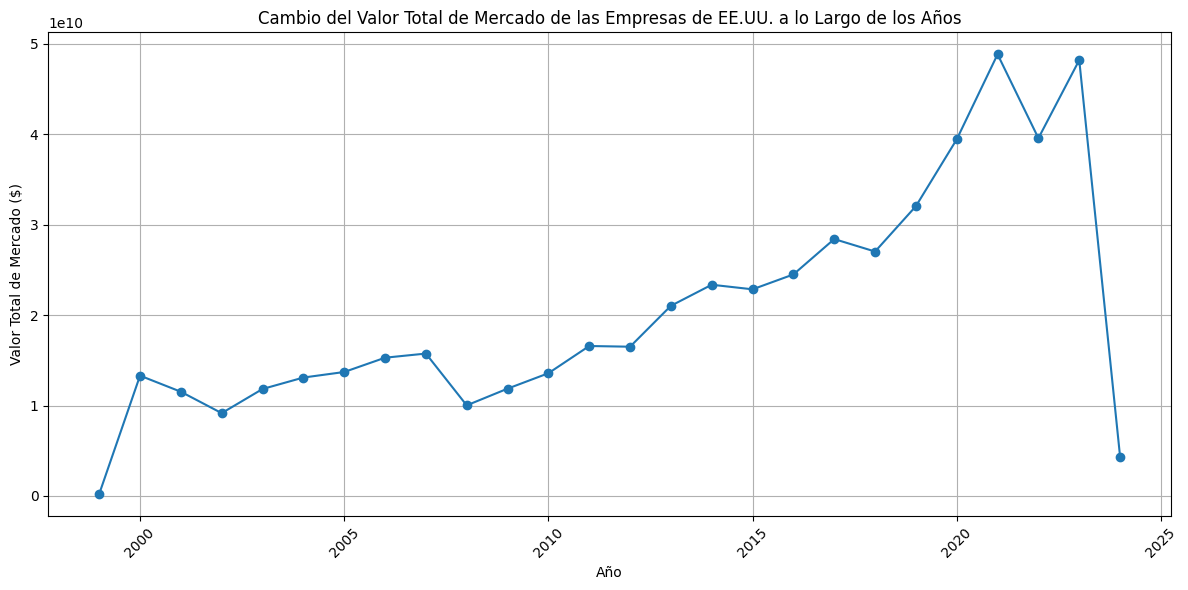

In [ ]:
annual_data = data[data['fiscalmonth'] == 12]

annual_data['MARKETVALUE'] = annual_data['MARKETVALUE']

total_market_value_per_year = annual_data.groupby('yearf')['MARKETVALUE'].sum().reset_index()

print("Total market value of the US market over the years:")
print(total_market_value_per_year)

plt.figure(figsize=(12, 6))
plt.plot(total_market_value_per_year['yearf'], total_market_value_per_year['MARKETVALUE'], marker='o')
plt.title('Cambio del Valor Total de Mercado de las Empresas de EE.UU. a lo Largo de los Años')
plt.xlabel('Año')
plt.ylabel('Valor Total de Mercado ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La razón por la que el año 2024 tiene una caída significativa es debido a que los datos apenas están a la mitad de este año. No tenemos el panorama completo del 2024 porque todavía no ha terminado. Sin embargo. Es muy curioso que la mitad del año 2024 sea mayor al market value de 1999. Esto se puede deber a factores como la inflación, pero no deja de ser interesante.

## How total revenue and total net income of all US firms has changed over the years? Do a table and/or graph and explain



<ipython-input-21-c049b707c5c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_data['NETINCOME'] = annual_data['NETINCOME'].fillna(0)


Total market value of the US market over the years:
     yearf     NETINCOME
0   1999.0  5.573097e+06
1   2000.0  3.604507e+08
2   2001.0  6.081797e+07
3   2002.0 -4.390388e+07
4   2003.0  3.736873e+08
5   2004.0  4.408524e+08
6   2005.0  5.314932e+08
7   2006.0  6.554135e+08
8   2007.0  6.043789e+08
9   2008.0  3.133322e+08
10  2009.0  5.922775e+08
11  2010.0  7.136607e+08
12  2011.0  8.218364e+08
13  2012.0  7.765565e+08
14  2013.0  9.098735e+08
15  2014.0  8.846443e+08
16  2015.0  6.495996e+08
17  2016.0  7.694228e+08
18  2017.0  9.460264e+08
19  2018.0  1.015922e+09
20  2019.0  9.700696e+08
21  2020.0  5.492805e+08
22  2021.0  1.542041e+09
23  2022.0  1.456780e+09
24  2023.0  1.487107e+09
25  2024.0  1.248941e+08


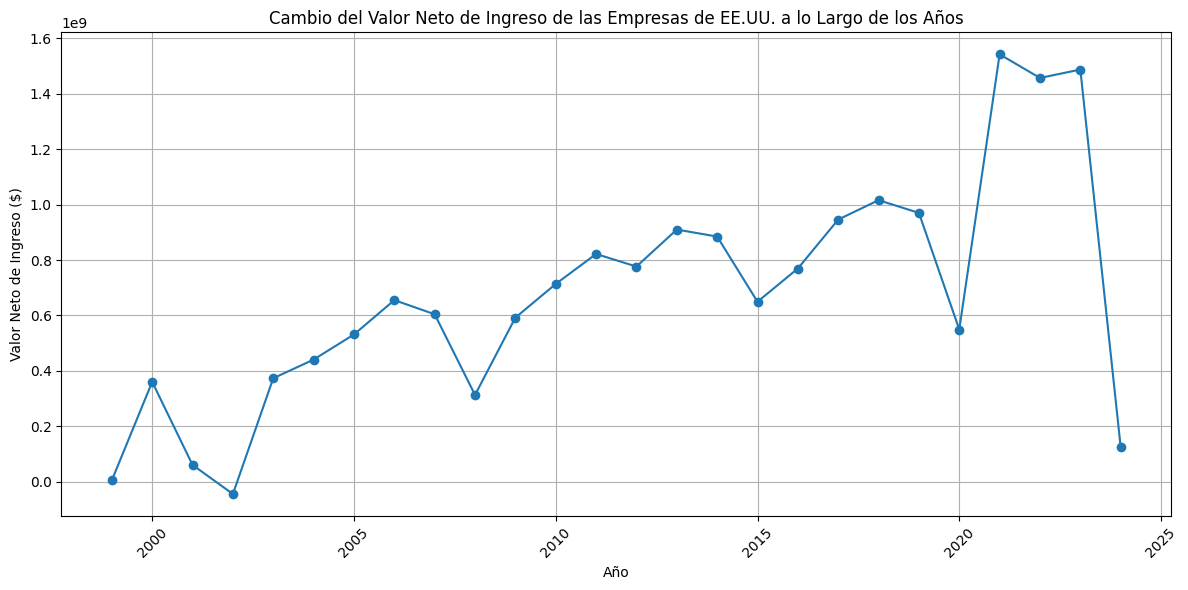

In [ ]:
annual_data['NETINCOME'] = annual_data['NETINCOME'].fillna(0)
total_net_income_per_year = annual_data.groupby('yearf')['NETINCOME'].sum().reset_index()

print("Total market value of the US market over the years:")
print(total_net_income_per_year)

plt.figure(figsize=(12, 6))
plt.plot(total_market_value_per_year['yearf'], total_net_income_per_year['NETINCOME'], marker='o')
plt.title('Cambio del Valor Neto de Ingreso de las Empresas de EE.UU. a lo Largo de los Años')
plt.xlabel('Año')
plt.ylabel('Valor Neto de Ingreso ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En la gráfica podemos observar lo mismo que la gráfica pasada, en el cual los valores de este año todavia no estan completos por lo tanto se ve este drop. Sin embargo, esta grafica representa muy bien la realidad, ya que en los años de 2008 y 2020 el ingreso neto de las firmas de Estados Unidos redujo. Esto tiene sentido por los eventos históricos que sucedieron durante estos años (asimismo por los eventos a principios de este siglo)

# 1.4 Learing about one industry
Industria: Servicios educativos

## 1.4.1 Descriptive statistics for your industry


In [ ]:
education_services = data[(data['Industria'] == 'Servicios educativos') & (data['yearf'] == 2023) & (data['fiscalmonth'] == 12)]

descriptive_stats = education_services[['revenue', 'totalassets', 'NETINCOME', 'TATE', 'DTE', 'DTTNW', 'DTEb']].describe()

print(descriptive_stats)
print("Variables independientes ponderadas: ")
print("TATE: ", wTATE)
print("DTE: ", wDTE)
print("DTTNW: ", wDTTNW)
print("DTEb: ", wDTEb)

            revenue   totalassets      NETINCOME       TATE        DTE  \
count  1.300000e+01  1.300000e+01      13.000000  13.000000  13.000000   
mean   1.169166e+06  1.709067e+06   62945.692308   2.479500   0.609503   
std    1.082584e+06  1.828987e+06   96674.598623   2.164383   0.752176   
min    1.767210e+05  1.585710e+05 -107294.000000   1.197161   0.003149   
25%    6.074080e+05  7.406850e+05   12322.000000   1.796094   0.122918   
50%    7.289370e+05  1.007316e+06   69791.000000   1.909013   0.498408   
75%    1.450826e+06  2.125213e+06  126867.000000   2.076808   0.629355   
max    4.414877e+06  7.187730e+06  205288.000000   9.466360   2.770939   

           DTTNW       DTEb  
count  13.000000  13.000000  
mean    0.874822   2.835171  
std     1.735391   6.268273  
min    -1.802722  -3.962675  
25%     0.040324  -0.009221  
50%     0.454726   1.394127  
75%     1.689261   3.147041  
max     5.595139  16.165305  
Variables independientes ponderadas: 
TATE:  5.133906637265474


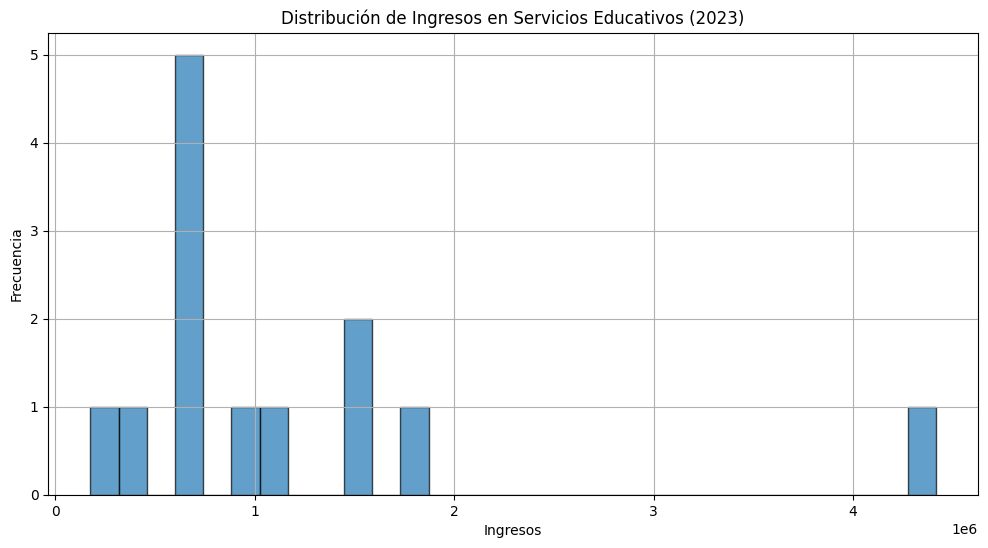

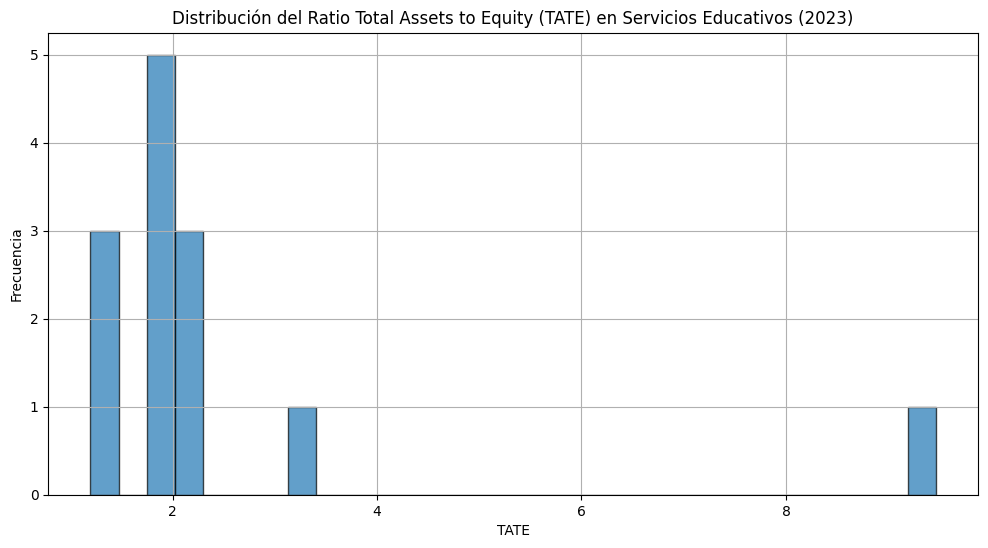

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(education_services['revenue'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de Ingresos en Servicios Educativos (2023)')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(education_services['TATE'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución del Ratio Total Assets to Equity (TATE) en Servicios Educativos (2023)')
plt.xlabel('TATE')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

## Interpretación

En el año fiscal 2023, las empresas en la industria de servicios educativos muestran una variabilidad significativa en los ingresos y en el ratio de apalancamiento. Mientras que el promedio de ingresos es bastante alto, existe una amplia gama en los valores de ingresos, reflejando una industria con una considerable disparidad en el tamaño de las empresas. El ratio de apalancamiento (TATE) también varía notablemente, lo que indica que las estrategias de financiamiento y la dependencia de deuda entre las empresas son muy diferentes.

En 2023, los ingresos promedio de las empresas en la industria de servicios educativos son de aproximadamente 1.17 USD millones, lo que refleja un nivel relativamente alto para la mayoría de las empresas del sector. Sin embargo, la alta desviación estándar de 1,082,584 USD sugiere una gran variabilidad en los ingresos, con algunos empresas reportando ingresos significativamente mayores o menores. Los ingresos varían desde un mínimo de 176,721 USD hasta un máximo de 4,414,877 USD. La mediana de 728,937 USD indica que la mitad de las empresas ganan menos y la otra mitad más que este valor, mientras que el 25% superior alcanza ingresos superiores a 1,450,826 USD.

El ratio promedio de activos totales a patrimonio (TATE) es 2.48, indicando que, en promedio, las empresas tienen 2.48 veces más activos que patrimonio (o propiedades como me comentó el profe en clase), lo que sugiere un nivel más o menos moderado de apalancamiento. La alta desviación estándar de 2.16 muestra una gran variabilidad en el apalancamiento entre las empresas, con algunas siendo mucho más apalancadas que otras. El ratio varía desde un mínimo de 1.20 hasta un máximo de 9.47, con la mediana en 1.91 y el 25% superior por encima de 2.08, reflejando diferencias significativas en las estrategias de financiamiento y dependencia de deuda entre las empresas de .

## 1.4.2 Correlation matrix

<ipython-input-24-865828131d9b>:19: RuntimeWarning: invalid value encountered in log
  'log_NETINCOME': np.log(last_row['NETINCOME']),
<ipython-input-24-865828131d9b>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_data = data_filtered.groupby(['Empresa', 'yearf']).apply(calcular_metricas).reset_index()


                          Empresa   yearf  annual_return   adjprice  \
0    Adtalem Global Education Inc  2000.0            NaN  24.384049   
1    Adtalem Global Education Inc  2001.0      36.624109  33.314490   
2    Adtalem Global Education Inc  2002.0     -36.766332  21.065974   
3    Adtalem Global Education Inc  2003.0       1.970231  21.481022   
4    Adtalem Global Education Inc  2004.0      17.732928  25.290236   
..                            ...     ...            ...        ...   
306                     Zovio Inc  2018.0     -15.542169   7.010000   
307                     Zovio Inc  2019.0     -70.613409   2.060000   
308                     Zovio Inc  2020.0     130.097087   4.740000   
309                     Zovio Inc  2021.0     -73.206751   1.270000   
310                     Zovio Inc  2022.0     -94.016736   0.143000   

     log_totalassets  log_revenue  log_NETINCOME       TATE       DTE  \
0          12.697957    13.135919      10.774383   1.452787  0.000000   
1

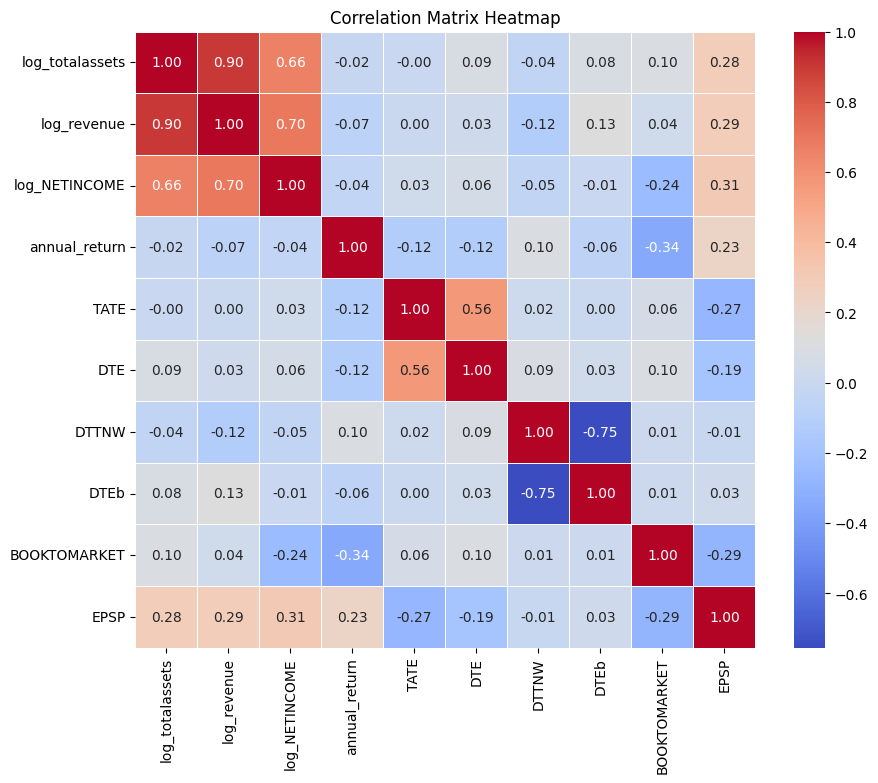

In [ ]:
# Filtrar solo la industria de Servicios educativos
data_filtered = data[data['Industria'] == 'Servicios educativos']

# Ordenar los datos por Empresa y fecha fiscal
data_filtered = data_filtered.sort_values(['Empresa', 'yearf', 'fiscalmonth'])

# Calcular el retorno anual utilizando shift
data_filtered['prev_year_price'] = data_filtered.groupby('Empresa')['adjprice'].shift(4)
data_filtered['annual_return'] = ((data_filtered['adjprice'] / data_filtered['prev_year_price']) - 1) * 100

# Función para calcular los logaritmos y obtener los últimos valores
def calcular_metricas(group):
    last_row = group.iloc[-1]
    return pd.Series({
        'annual_return': last_row['annual_return'],
        'adjprice': last_row['adjprice'],
        'log_totalassets': np.log(last_row['totalassets']),
        'log_revenue': np.log(last_row['revenue']),
        'log_NETINCOME': np.log(last_row['NETINCOME']),
        'TATE': last_row['TATE'],
        'DTE': last_row['DTE'],
        'DTTNW': last_row['DTTNW'],
        'DTEb': last_row['DTEb'],
        'BOOKTOMARKET': last_row['BOOKTOMARKET'],
        'EPSP': last_row['EPSP'],
        'MARKETVALUE': last_row['MARKETVALUE'],
        'longdebt': last_row['longdebt'],
        'totalassets': last_row['totalassets'],
    })

# Agrupar por empresa y año fiscal, y aplicar la función
annual_data = data_filtered.groupby(['Empresa', 'yearf']).apply(calcular_metricas).reset_index()

# Imprimir resultados
print(annual_data)

# Definir las variables para la matriz de correlación
correlation_vars = ['log_totalassets', 'log_revenue', 'log_NETINCOME', 'annual_return', 'TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP']

# Obtener la matriz de correlación de las variables
correlation_matrix = annual_data[correlation_vars].corr()

# Hacer un plot para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Interpretación

**Matriz de correlación**

Podemos ver en la gráfica que entre los ratios que voy a utilizar en mi modelo de regresión no existe correlación o, si esta existe, es muy baja. Solo tenemos dos casos especiales en donde la matriz nos arroja que sí existe una correlación. En una de ellas no es muy fuerte, ya que tiene un valor aceptable de correlacion de 0.56, lo cual indica que entre las variables independientes (ratios) de TATE y DTE existe correlación pero no la suficiente para afectar mucho el modelo. Sin embargo, entre los ratios DTTNW y DTEb sí existe una relación fuerte con un valor de -0.75, lo cual indica que estas dos variables podría pelear por tener más influencia en el modelo final. Sin embargo, debido a que no está muy cercano el valor a -1, decidí dejarla para el cálculo de mi modelo final.

**¿Por qué está comentada la sección de reemplazar los NANs con el valor de la mediana de cada columna?**

**En mi solución final no utilicé la interpolación porque no tenía un gran efecto en los resultados pero esta explicación me pareció muy interesante así que decidí dejarla**

La razón por la que tomé esta decisión es debido a que esta imputación con la mediana no era una representación directa de la real.

Pongamos un ejemplo. Digamos que tenemos una empresa que se creó en el año 2000, justo cuando empieza a tomar los datos nuestro dataset. Obviamente, cuando es una empresa nueva, al principio no va a tener ni de cerca las ganancias que pueda tener en un futuro. Incluso, la mayoría de los meses iniciales estarán con valores vacíos en sus ratios financieros, ¡porque no hay nada con que calcularlos! Entonces, si a esa empresa le empieza a ir muy bien (como NVIDIA) sus ratios van a subir muchisimo porque ya tenemos más assets, más deudas y más valores de inversión que calcular. Y naturalmente, sus medianas, medias y medias ponderadas van a aumentar drasticamente.

Entonces lo que estaba haciendo aqui era de que le estaba asignando a los valores nulos el valor de la mediana. Eso está bien, ¡pero no para empresas nuevas! Porque digamos que del mes 1-6 no tuvieron ningún registro de sus ratios y en el mes 7, por ejemplo tuvieron un 0.1 de TATE. Bueno, si le asignó la mediana a los valores nulos, entonces del mes 1-6 tendré el valor de la mediana (que puede ser muy alto) y en el mes 7 tendré un bajón impresionante en mis valores, a pesar de que ese era la primera vez que se podían calcular los ratios.

Por esa misma razón, decidí implementar la interpolarización, que lo que hace es de que a los valores nulos les asigna un valor que vaya de acuerdo con la tendencia en ese punto del tiempo. Entonces, regresemos al ejemplo, del mes 1-6 en vez de asignarle el valor de la mediana, le asignará un valor que sea lo que 'más probable hubiera sido' ya que toma en consideración toda la tendencia de los datos, no solo el valor de los datos de la mediana.

## 1.4.3 Regression Model


### TATE

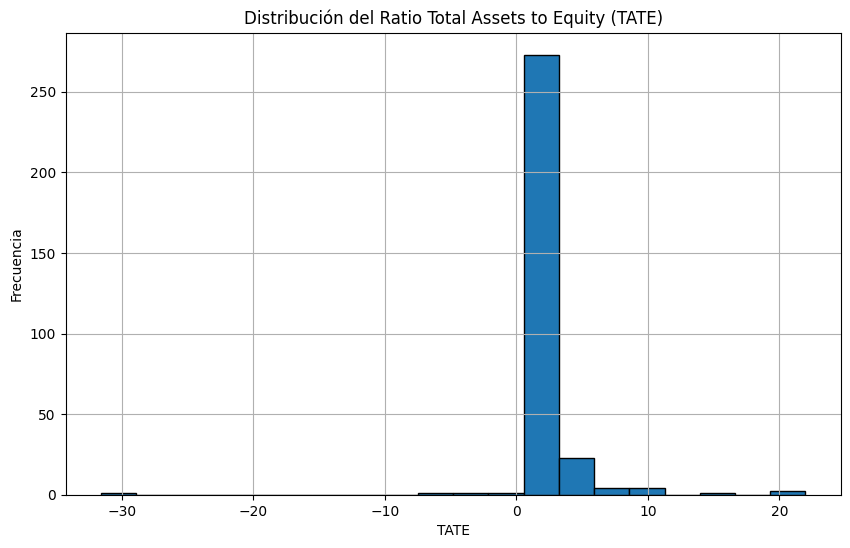

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(annual_data['TATE'], bins=20, edgecolor='black')
plt.title('Distribución del Ratio Total Assets to Equity (TATE)')
plt.xlabel('TATE')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

La mayoría de los valores de TATE están cerca de cero, lo que sugiere que muchas empresas tienen un ratio de activos totales a patrimonio cercano a cero. Sin embargo, podemos observar que hay varios casos en los que los valores de TATE se salen de la tendencia (los casos de -30 y 20 por ejemplo)

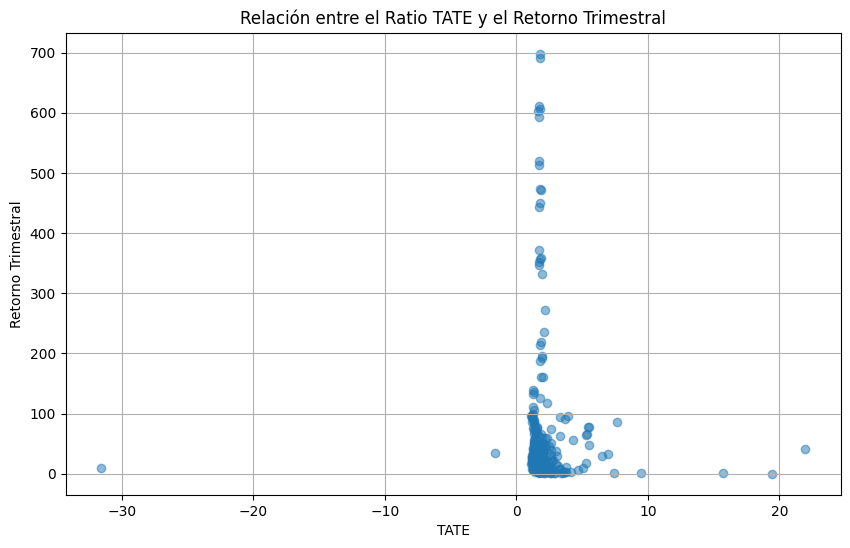

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(annual_data['TATE'], annual_data['adjprice'], alpha=0.5)
plt.title('Relación entre el Ratio TATE y el Retorno Trimestral')
plt.xlabel('TATE')
plt.ylabel('Retorno Trimestral')
plt.grid(True)
plt.show()


La mayoría de los puntos de datos están concentrados en la parte inferior izquierda del gráfico, indicando que la mayoría de las empresas tienen un TATE bajo y retornos trimestrales relativamente bajos. Sin embargo, hay un punto atípico notable con un retorno trimestral extremadamente alto (y también uno muuy bajo), lo que sugiere una variabilidad significativa en los retornos trimestrales para ciertas empresas con valores específicos de TATE.

Esto se tiene que tomar en consideración que PUEDE afectar negativamente el comportamiento de nuestro modelo de regresión

### DTE

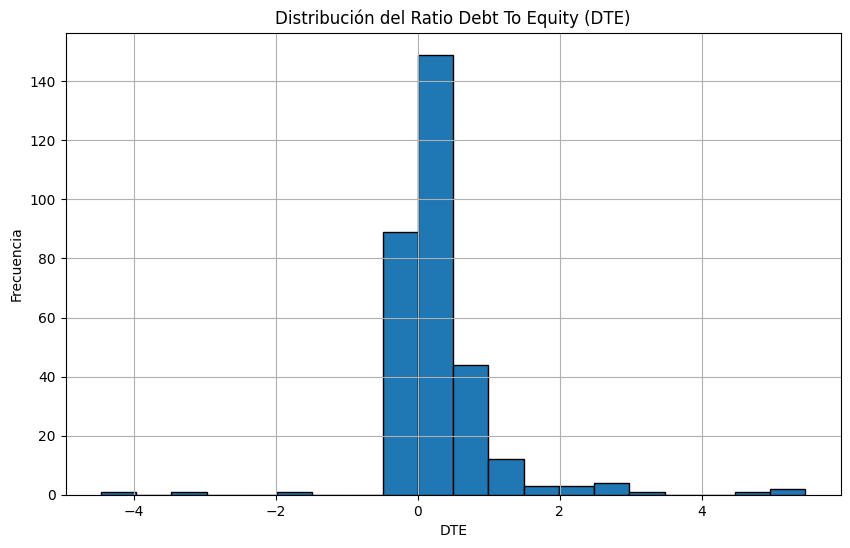

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(annual_data['DTE'], bins=20, edgecolor='black')
plt.title('Distribución del Ratio Debt To Equity (DTE)')
plt.xlabel('DTE')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

 La mayoría de los valores de DTE están cerca de cero. Esto sugiere que muchas entidades tienen un ratio de deuda a patrimonio cercano a cero en el conjunto de datos analizado.

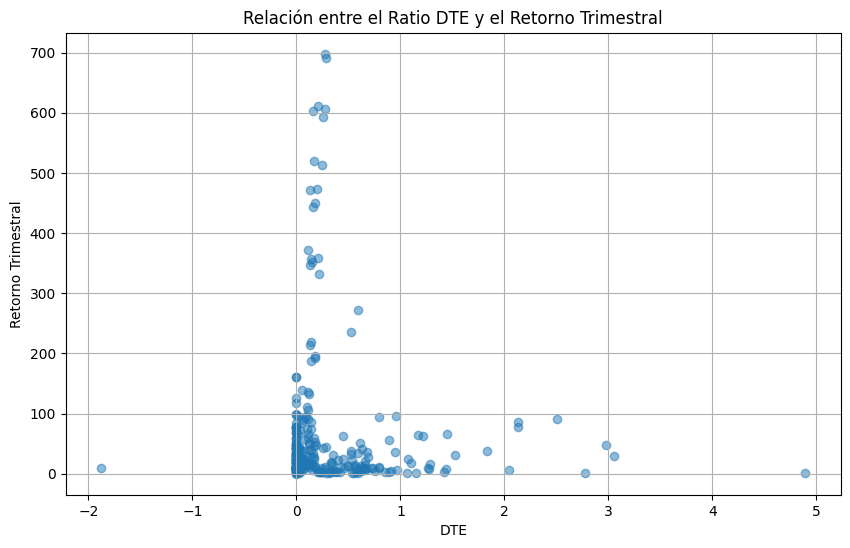

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(annual_data['DTE'], annual_data['adjprice'], alpha=0.5)
plt.title('Relación entre el Ratio DTE y el Retorno Trimestral')
plt.xlabel('DTE')
plt.ylabel('Retorno Trimestral')
plt.grid(True)
plt.show()

En general, parece que la mayoría de las empresas en este conjunto de datos tienen una proporción de deuda a patrimonio relativamente baja. Sin embargo, el gráfico también muestra que hay algunas empresas atípicas con valores de DTE más altos.

### DTTNW

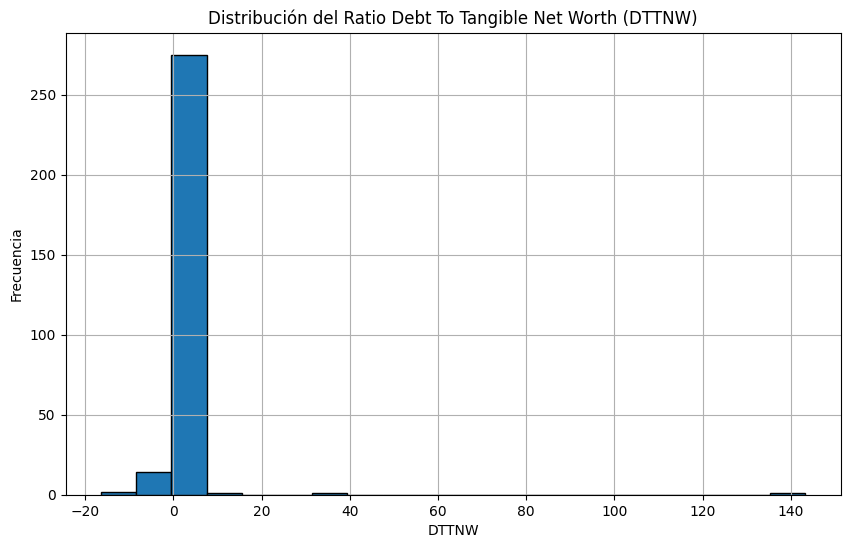

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(annual_data['DTTNW'], bins=20, edgecolor='black')
plt.title('Distribución del Ratio Debt To Tangible Net Worth (DTTNW)')
plt.xlabel('DTTNW')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

 Esta gráfica muestra cómo se distribuyen los valores de DTTNW en el conjunto de datos, y la mayoría de las empresas parecen tener una proporción de deuda a patrimonio relativamente baja.

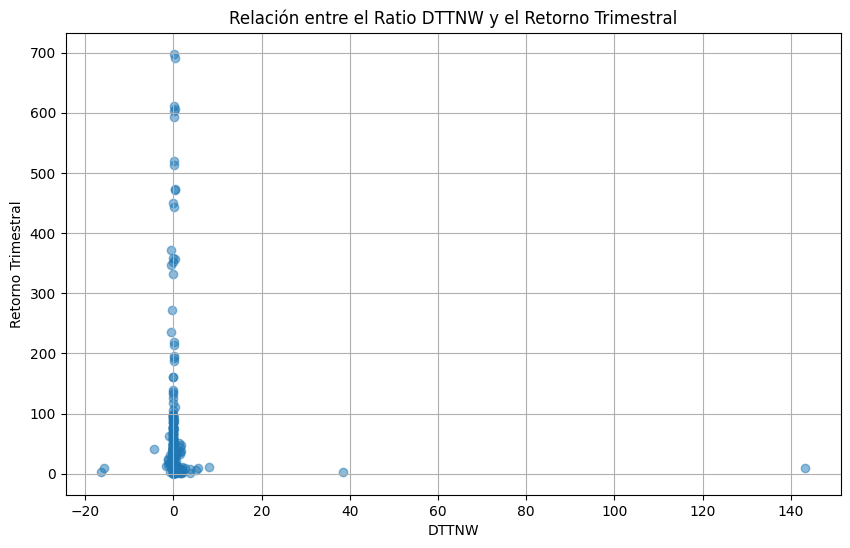

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(annual_data['DTTNW'], annual_data['adjprice'], alpha=0.5)
plt.title('Relación entre el Ratio DTTNW y el Retorno Trimestral')
plt.xlabel('DTTNW')
plt.ylabel('Retorno Trimestral')
plt.grid(True)
plt.show()

Aunque la mayoría de los datos están concentrados cerca de cero, hay algunos valores atípicos dispersos en diferentes puntos de DTNW, lo que sugiere variabilidad en los retornos trimestrales para ciertas empresas con valores específicos de DTNW.

### DTEb

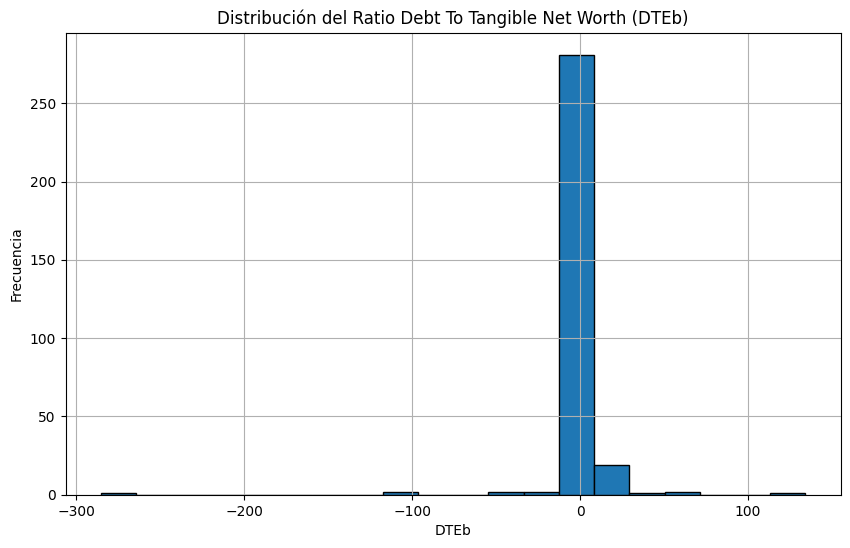

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(annual_data['DTEb'], bins=20, edgecolor='black')
plt.title('Distribución del Ratio Debt To Tangible Net Worth (DTEb)')
plt.xlabel('DTEb')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

En resumen, esta gráfica muestra cómo se distribuyen los valores de DTED en el conjunto de datos, y la mayoría de las empresas parecen tener una proporción de deuda a patrimonio tangible similar dentro del rango de -100 a 200.

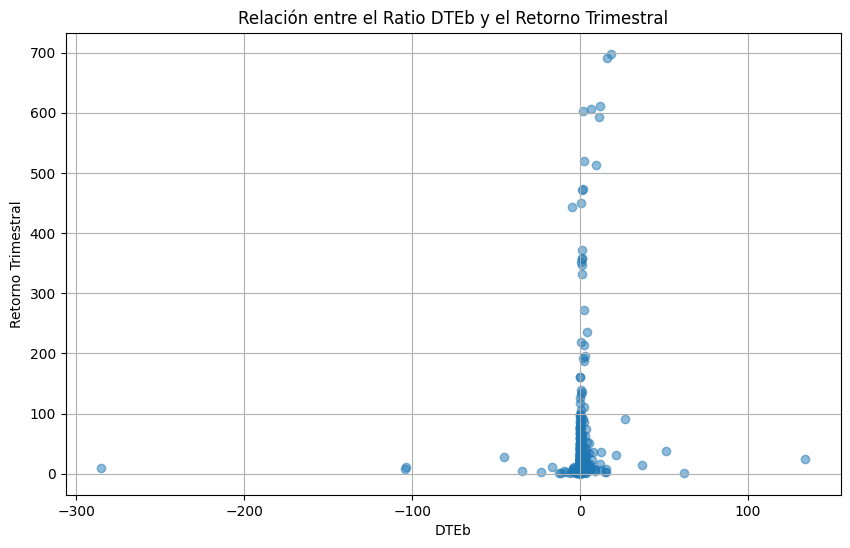

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(annual_data['DTEb'], annual_data['adjprice'], alpha=0.5)
plt.title('Relación entre el Ratio DTEb y el Retorno Trimestral')
plt.xlabel('DTEb')
plt.ylabel('Retorno Trimestral')
plt.grid(True)
plt.show()

Aunque la mayoría de los datos están concentrados cerca de cero, hay algunos valores atípicos dispersos en diferentes puntos de DTEb, lo que sugiere variabilidad en los retornos trimestrales para ciertas empresas con valores específicos de DTEb.

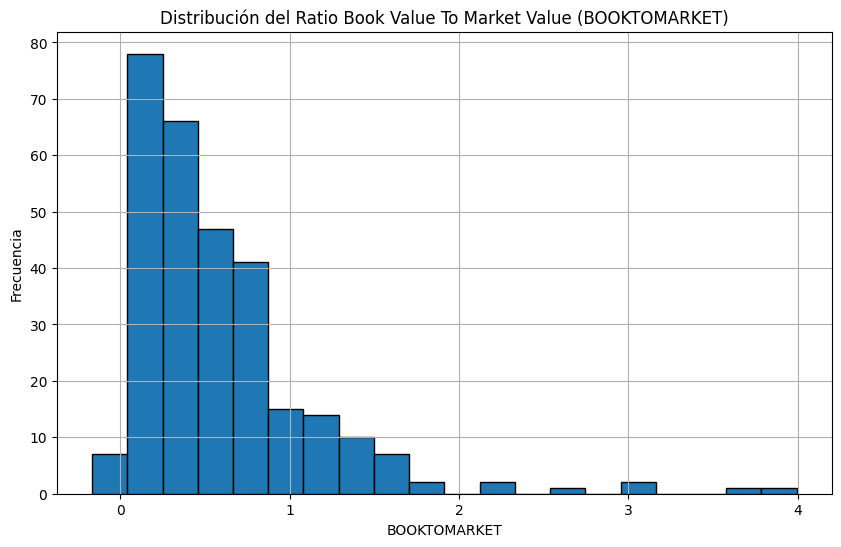

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(annual_data['BOOKTOMARKET'], bins=20, edgecolor='black')
plt.title('Distribución del Ratio Book Value To Market Value (BOOKTOMARKET)')
plt.xlabel('BOOKTOMARKET')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

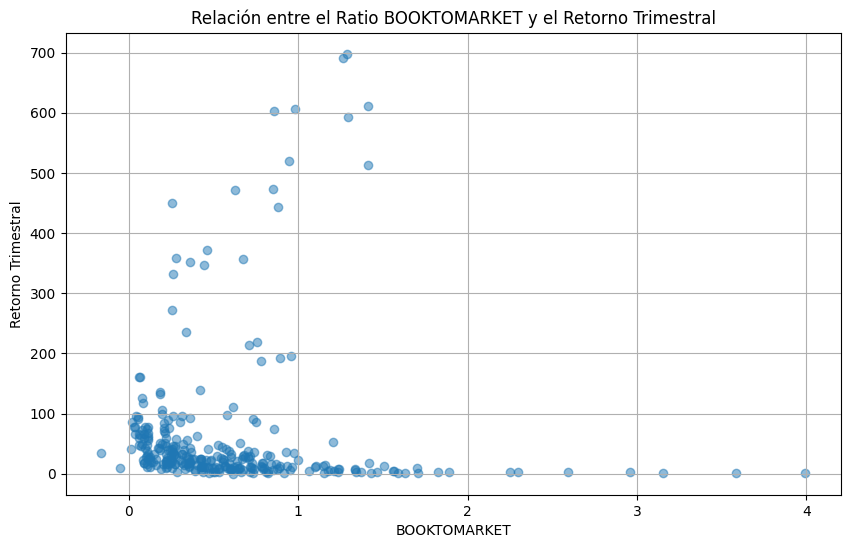

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(annual_data['BOOKTOMARKET'], annual_data['adjprice'], alpha=0.5)
plt.title('Relación entre el Ratio BOOKTOMARKET y el Retorno Trimestral')
plt.xlabel('BOOKTOMARKET')
plt.ylabel('Retorno Trimestral')
plt.grid(True)
plt.show()

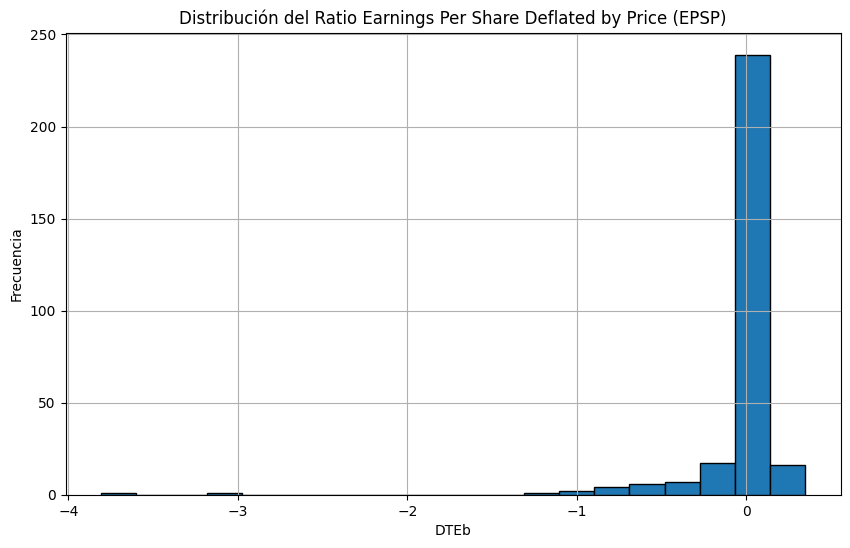

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(annual_data['EPSP'], bins=20, edgecolor='black')
plt.title('Distribución del Ratio Earnings Per Share Deflated by Price (EPSP)')
plt.xlabel('DTEb')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

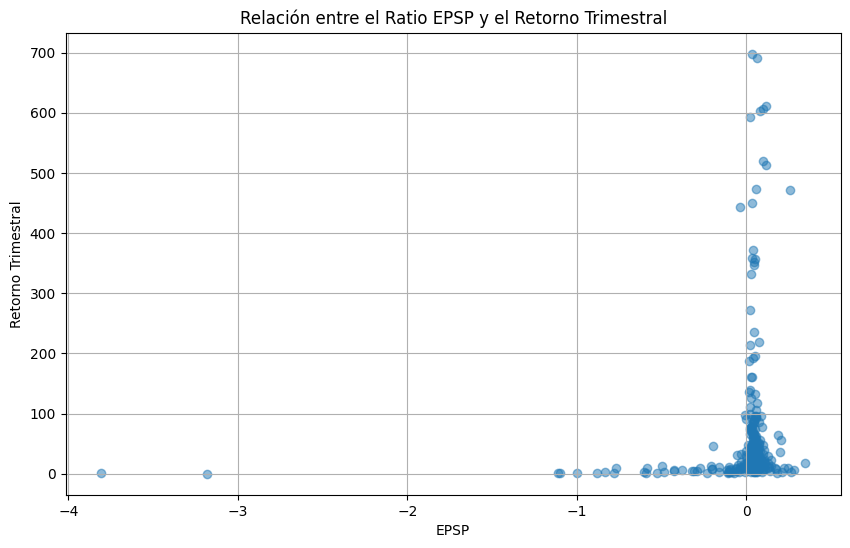

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(annual_data['EPSP'], annual_data['adjprice'], alpha=0.5)
plt.title('Relación entre el Ratio EPSP y el Retorno Trimestral')
plt.xlabel('EPSP')
plt.ylabel('Retorno Trimestral')
plt.grid(True)
plt.show()

In [ ]:
import statsmodels.api as sm

# Filtrar datos relevantes
df = annual_data[['Empresa','annual_return', 'TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP']]
print(df.info())

# Separar variables independientes y dependientes
X = df[['TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET','EPSP']]
y = df['annual_return']

# Agregar una columna de 1's para el intercepto
X = sm.add_constant(X)

# Crear el modelo de regresión OLS
model = sm.OLS(y, X, missing='drop')

# Ajustar el modelo con los datos de entrenamiento
results = model.fit()

# Mostrar el resumen del modelo
print(results.summary())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Empresa        311 non-null    object 
 1   annual_return  274 non-null    float64
 2   TATE           311 non-null    float64
 3   DTE            311 non-null    float64
 4   DTTNW          294 non-null    float64
 5   DTEb           311 non-null    float64
 6   BOOKTOMARKET   294 non-null    float64
 7   EPSP           294 non-null    float64
dtypes: float64(7), object(1)
memory usage: 19.6+ KB
None
                            OLS Regression Results                            
Dep. Variable:          annual_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     8.152
Date:                Mon, 14 Oct 2024   Prob (F-statistic):           4.18e-08
Tim

### Interpretación 1
Este fue el primer resultado de mi modelo y decidí dejarlo aquí para que se pueda ver QUE TAN MAL estaba. Creo que vale la pena dejarlo para ver qué tanto he progresado desde entonces y tambien por los conceptos del signficado de los coeficientes

#### Coeficientes del Modelo

- **Intercepto: 1,913,520.10**

  Este valor representa el valor esperado de la variable dependiente (annual return) cuando todos los ratios financieros son cero. En un contexto práctico, este intercepto no siempre tiene una interpretación directa, especialmente si los valores cero para las variables independientes no son realistas en tu contexto.

- **TATE: -80,225.35**

    Este coeficiente negativo sugiere que, manteniendo los otros ratios constantes, un aumento en el ratio (Total Assets to Equity) se asocia con una disminución en el retorno anual de las acciones.
  
- **DTE: 74,338.10**

    Este coeficiente positivo sugiere que, manteniendo los otros ratios constantes, un aumento en el ratio (Debt to Equity) se asocia con un incremento en el retorno anual de las acciones.
  
- **DTTNW: -7,615.63**
    Este coeficiente negativo sugiere que, manteniendo los otros ratios constantes, un aumento en el ratio (Debt To Tangible Net Worth) se asocia con una disminución en el retorno anual de las acciones.
  
- **DTEb: 178,125.02**
    Este coeficiente positivo sugiere que, manteniendo los otros ratios constantes, un aumento en el ratio (Debt to EBITDA) se asocia con un incremento en el retorno anual de las acciones.

#### R-cuadrado del Modelo

**R-cuadrado: -0.047**
  - Un R-cuadrado negativo sugiere que el modelo de regresión no está capturando bien la variabilidad en el retorno anual y que el modelo no es muy preciso. En términos prácticos, esto significa que los ratios financieros seleccionados no explican significativamente el retorno anual de las acciones. Un R-cuadrado negativo es inusual y podría indicar problemas con la calidad del modelo o la selección de variables.

#### Conclusión de los Resultados

El modelo de regresión múltiple, en este caso, no muestra un buen ajuste para explicar los retornos anuales de las acciones, dado el R-cuadrado negativo. Los coeficientes obtenidos sugieren relaciones teóricas entre los ratios financieros y el retorno anual, pero la falta de ajuste del modelo sugiere que otros factores podrían estar influyendo en el retorno anual o que los ratios seleccionados no capturan adecuadamente estas relaciones. Puede que esto nos indique que lo mejor seria ver otros ratios que a lo mejor puedan tener un mayor impacto en la predicción de retornos anuales.

### Interpretación 2

**Hipótesis**
- Hipótesis Alternativa: Que el coeficiente no sea cero
- Hipótesis Nula: Que el coeficiente sea cero

**Valor p (p-value) y significancia estadística**
1. P-value: El p-value ayuda a determinar la significancia estadística de los coeficientes del modelo de regresión. Un valor p bajo indica que es improbable que el coeficiente sea cero bajo el supuesto nulo.
2. Significativo (p < 0.05): Si el p-value es menor que 0.05, podemos concluir que el coeficiente es estadísticamente significativo, ya que tenemos suficiente evidencia para aprobar la hipótesis alternativa.
2. No Significativo (p > 0.05): Si el p-value es mayor que 0.05, podemos concluir que el coeficiente no es estadísticamente significativo, ya que no tenemos suficiente evidencia para aprobar la hipótesis alternativa.

**Coeficientes**
1. Intercepto (constante)
 - Coeficiente: 28.79
 - Interpretación: El intercepto indica que, cuando todas las variables independientes son cero, el retorno anual esperado es de 28.79 unidades. Sin embargo, esta intepretación no es realista porque es muy poco probable que todas las variables independientes (ratios) sean 0 en un mismo periodo de tiempo.
  - Signifcancia: El p-value es 0.000, lo que sugiere que el intercepto es estadísticamente significativo.

2. TATE (Total Assets to Equity):
 - Coeficiente: -0.60
 - Interpretación: Por cada unidad de incremento en TATE, el retorno anual disminuye en 0.60 unidades
 - Significancia: El p-value es 0.59, lo cual indica que el coeficiente no es estadísticamente signficativo.

3. DTE (Debt to Equity):
 - Coeficiente: -5.90
 - Interpretación: Por cada unidad de incremento en DTE, el retorno anual disminuye en 5.91 unidades
 - Significancia: El p-value es 0.299, lo cual indica que el coeficiente no es estadísticamente signficativo.

4. DTTNW (Debt to Tangible Net Worth):
 - Coeficiente: 0.76
 - Interpretación: Por cada unidad de incremento en DTTNW, el retorno anual aumenta en 0.76 unidades
 - Significancia: El p-value es 0.11, lo cual indica que el coeficiente no es estadísticamente signficativo.

5. DTEb (Debt to EBITDA):
 - Coeficiente: 0.09
 - Interpretación: Por cada unidad de incremento en DTTNW, el retorno anual aumenta en 0.09 unidades
 - Significancia: El p-value es 0.616, lo cual indica que el coeficiente no es estadísticamente signficativo.

6. BOOKTOMARKET (Book to Market Ratio):
 - Coeficiente: -26.40
 - Interpretación: Por cada unidad de incremento en DTTNW, el retorno anual disminuye en 26.41 unidades
 - Significancia: El p-value es 0, lo cual indica que el coeficiente es estadísticamente signficativo.

7. EPSP (Earnings per share price):
 - Coeficiente: 16.56
 - Interpretación: Por cada unidad de incremento en DTTNW, el retorno anual disminuye en 16.56 unidades
 - Significancia: El p-value es 0.052, lo cual indica que el coeficiente está muy cerca de ser estadísticamente signficativo.

**Magnitud del modelo**
- R^2: 0.155

 La R cuadrada del modelo es 0.155, lo que significa que el 15.5% de la variabilidad en el retorno anual de empresas pertenecientes al sector educativo es explicada por las variables independientes del modelo (ratios). Aunque esto representa una mejora respecto a la versión anterior, el modelo sigue teniendo una capacidad limitada para explicar la variabilidad en el retorno anual.

 Sin embargo, por ser un modelo que trata de predecir retornos anuales (que realísticamente es muy impredecible) considero que el 15% de R^2 no es un mal primer acercamiento.

**Conclusión**

El modelo de regresión ha mejorado con un R cuadrado de 0.155, lo que sugiere que las variables explicativas (ratios) ahora capturan más variabilidad en los retornos anuales. Pero, como nos pudimos dar cuenta en la interpretación, solo el BOOKTOMARKET y el EPSP tienen un peso mayor en la explicación de estas variables (aunque el EPSP no lo podemos confirmar con certeza).

### Siguientes pasos:
Hemos visto que existe una gran variabilidad en nuestras variables independientes. Esto es algo que lo vemos reflejado en los resultados, ya que todavía no explicamos la variabilidad de los datos con certeza.

Esto es comprensible, ya que esta es nuestra 2da iteración del modelo y no estamos usando técnicas complejas de gestión, limpieza y transformación de datos.

Esto es algo que sí tenemos que tener 'al toque' porque si tenemos nuestros datos mal interpretados y procesados, no importa que tengamos un buen resultado en nuestro modelo, eso no va a reflejar la realidad de los retornos anuales.

Por lo tanto, he decidio proceder a mejorar mi primer modelo, utilizando técnicas de identificación de valores extremos en mis parámetros (mis variables independientes como TATE, DTE), identificación de valores extremos en mis resultados de retorno anual y al final la toma de decisiones para determinar qué es lo que vamos a hacer con esos valores que encontremos.

En la siguiente sección hablaré sobre: qué es la hat matrix, qué son los studentized residual, qué es el Cook distance, qué son los leverages y qué es la winsorización.

Estos conceptos(aunque tienen nombres muy imponentes) descubriremos que no son nada de qué temer.

In [ ]:
# Obtener el índice de las filas que se usaron en el modelo
used_index = results.model.data.row_labels

# Filtrar el DataFrame original para mantener solo las filas usadas en el modelo
df_filtered = df.loc[used_index]

# Verificar el número de filas
print(f"Número de filas en df_filtered: {len(df_filtered)}")

X_filtered = sm.add_constant(df_filtered[['TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET','EPSP']])
y_filtered = df_filtered['annual_return']

Número de filas en df_filtered: 274


                        Empresa  annual_return      TATE       DTE     DTTNW  \
1  Adtalem Global Education Inc      36.624109  1.375887  0.000000 -0.000000   
2  Adtalem Global Education Inc     -36.766332  1.322679  0.000000 -0.000000   
3  Adtalem Global Education Inc       1.970231  2.060890  0.661587 -0.344641   
4  Adtalem Global Education Inc      17.732928  1.848655  0.449549 -0.221511   
5  Adtalem Global Education Inc     -27.425237  1.791676  0.344540 -0.453796   

       DTEb  BOOKTOMARKET      EPSP  predicted_annual_return  
1  0.000000      0.113002  0.022935                25.357512  
2  0.000000      0.221471  0.042005                22.840866  
3  3.134367      0.255125  0.037531                17.565514  
4  2.410584      0.248172  0.030128                19.030865  
5  3.995981      0.362419  0.020367                16.482711  


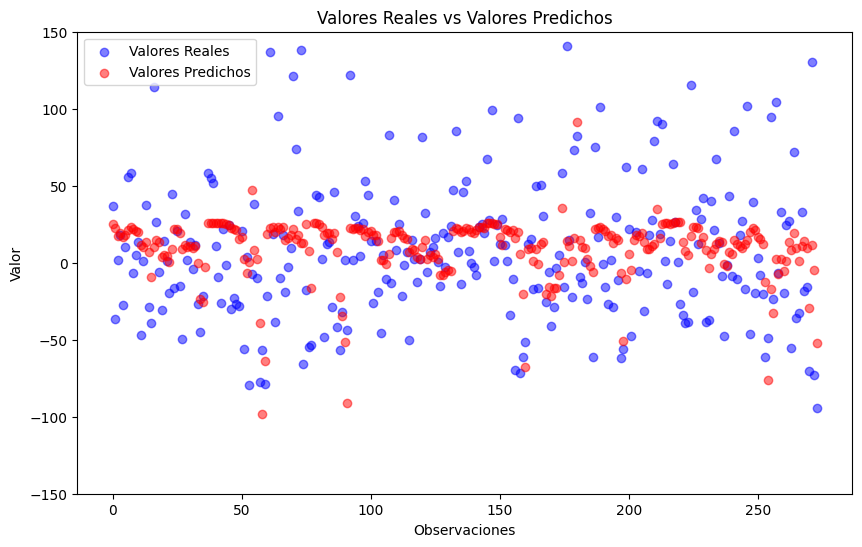

In [ ]:
y_pred = results.predict(X_filtered)

# Agregar las predicciones al DataFrame filtrado
df_filtered['predicted_annual_return'] = y_pred

# Mostrar las primeras filas del DataFrame filtrado
print(df_filtered.head())

# Crear la figura
plt.figure(figsize=(10, 6))

# Graficar los valores reales
plt.scatter(range(len(y_filtered)), y_filtered, color='blue', alpha=0.5, label='Valores Reales')

# Graficar los valores predichos
plt.scatter(range(len(y_filtered)), y_pred, color='red', alpha=0.5, label='Valores Predichos')

# Configurar el título y las etiquetas
plt.title('Valores Reales vs Valores Predichos')
plt.xlabel('Observaciones')
plt.ylim(-150,150)
plt.ylabel('Valor')
plt.legend()

# Mostrar la figura
plt.show()


Antes de pasar a la siguiente sección, grafico mis resultado de mi 1er modelo

Esta gráfica me ayuda para tener una representación visual de mis resultados y darme cuenta que en mi modelo tengo ciertos outliers con los que tengo que trabajar. También puedo ver la tendencia de los resultados predecidos tanto los valores reales que son los que se esperan.

Vemos que las tendencias de los valores reales y los valores predichos no siguen el mismo comportamiento. Por lo tanto, esto me dice que mi modelo no está capturando la tendencia general de los datos del retorno anual.

Para ello utilizaré las técnicas de identificación de outliers de "Cook's Distance" y "Studentized Residuals"

### Métodos de identificación de outliers

In [ ]:
# Obtener la influencia de cada observación
influence = results.get_influence()
# Obtener el cook distance de cada observacion
cooks_distance = influence.cooks_distance

df_filtered['cooks_distance'] = cooks_distance[0]
df_filtered['is_cooks_distance'] = df_filtered['cooks_distance'] > 4/len(df_filtered)

Lo primero que tenemos que hacer es calcular la influencia, que nos ayudará a obtener informacion sobre las instancias que tienen mayor influencia en los resultados del retorno anual.

Para conocer cuáles son estas instancias con mayor precisión utilizaré dos métodos que me ayudarán como criterio de toma de decisiones para identificar cuáles son los puntos que no siguen la tendencia del modelo (estos puntos son conocidos como outliers):
- Cook's Distance: Método para medir cuánto cambian los coeficinetes del modelo cuando se excluye una observación en particular.
- Studentized Residuals: Versión ajustada de la diferencia entre el valor real y el valor predicho por el modelo en el que divides el residuo entre su desviación estándar estimada

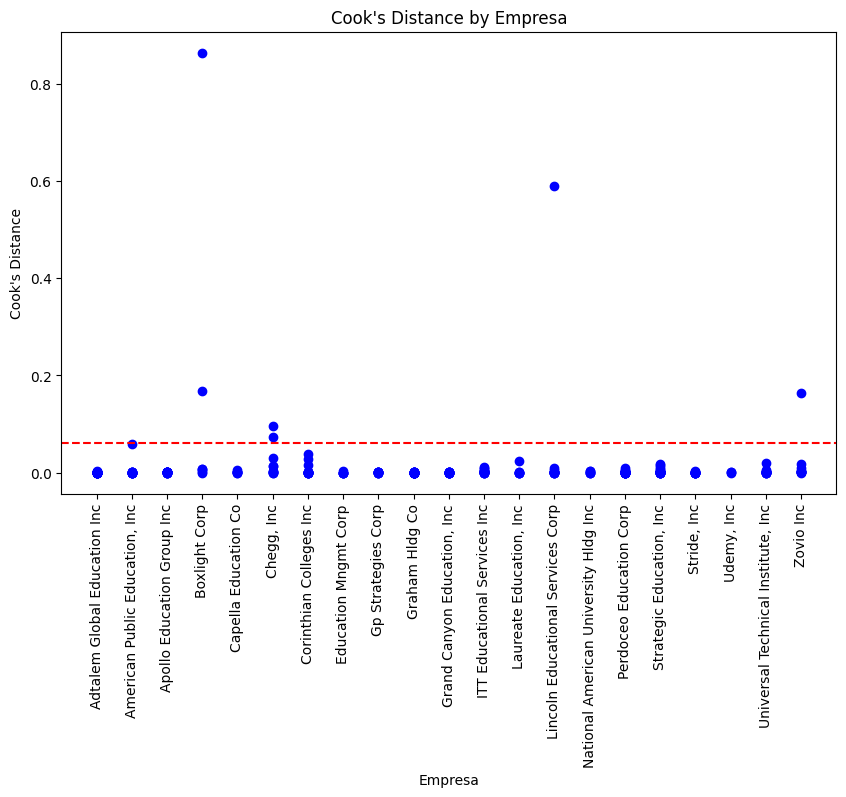

In [ ]:
# Graficar Cook's Distance
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Empresa'], df_filtered['cooks_distance'], color='blue')
plt.axhline(y=0.06, color='r', linestyle='--')
plt.xticks(rotation=90)  # Rotar etiquetas si hay muchas empresas
plt.title("Cook's Distance by Empresa")
plt.xlabel('Empresa')
plt.ylabel("Cook's Distance")
plt.show()

Lo que estamos haciendo en este gráfico es mostrar nuestros valores de cook distance y como podemos ver, mientras más grande sea el valor, más probabilidades tiene ser que esa instancia en específico sea un outlier.

En este caso tenemos que un retorno anual de Boxlight Corp está afectando en gran medida el modelo.

El criterio que estoy utilizando para determinar un outlier mediante Cook's Distance es que si un dato supera el umbral del 4/n (n siendo la cantidad de instancias del dataset) entonces tiene más probabilidad de ser un punto que no se comporte como el resto de los puntos. ¿Por qué este valor? El valor de 4/n ajusta la tolerancia a influencias en función del tamaño de la muestra. Con conjuntos de datos grandes, el umbral es más bajo porque hay más observaciones, por lo que un único punto influyente debe tener un impacto más pequeño para ser considerado problemático.

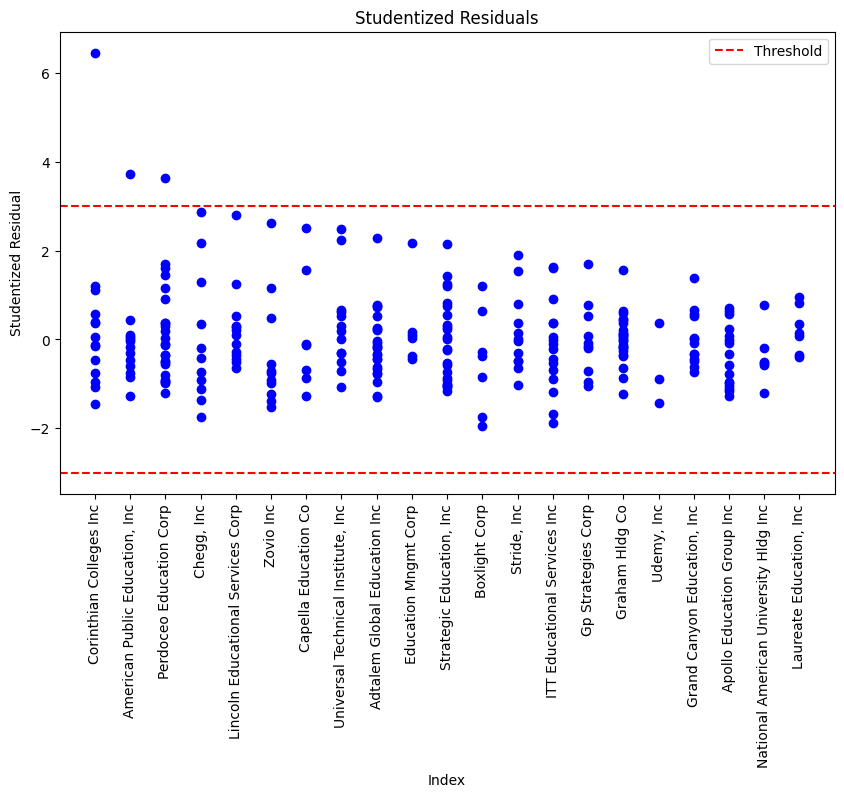

In [ ]:
# Calcular y agregar Studentized Residuals
stud_res = results.outlier_test()
df_filtered['student_resid'] = stud_res['student_resid']

# Marcar outliers
df_filtered['is_outlier'] = np.abs(df_filtered['student_resid']) > 2

# Ordenar el DataFrame por el valor absoluto de student_resid en orden descendente
df_filtered = df_filtered.sort_values(by='student_resid', key=abs, ascending=False)

# Graficar los studentized residuals
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Empresa'], df_filtered['student_resid'], color='blue')
plt.axhline(y=3, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-3, color='r', linestyle='--')
plt.xticks(rotation=90)  # Rotar etiquetas si hay muchas empresas
plt.title('Studentized Residuals')
plt.xlabel('Index')
plt.ylabel('Studentized Residual')
plt.legend()
plt.show()

Esta gráfica es muy similar a la de Cook's Distance pero ahora con los valores de Studentized Residuals. Por convención general, el criterio es que si un valor es mayor a 2 es posible outlier. Un valor mayor a 3 es altamente probable que sea un outlier. Y un valor mayor a 4 es prácticamente un outlier.

In [ ]:
# Contar el número de outliers
num_outliers = df_filtered['is_cooks_distance'].sum()
print(f"\nNúmero total de outliers(Cook's Distance): {num_outliers}")

# Ver solo los outliers
print("\nOutliers (Cook's Distance):")
print(df_filtered[df_filtered['is_cooks_distance']][['Empresa', 'cooks_distance', 'is_cooks_distance', 'student_resid' ,'is_outlier']])

# Contar el número de outliers
num_outliers = df_filtered['is_outlier'].sum()
print(f"\nNúmero total de outliers (Studentized Residuals): {num_outliers}")

# Ver solo los outliers
print("\nOutliers (Studentized Residuals):")
print(df_filtered[df_filtered['is_outlier']][['Empresa', 'cooks_distance', 'is_cooks_distance', 'student_resid' ,'is_outlier']])


Número total de outliers(Cook's Distance): 16

Outliers (Cook's Distance):
                                Empresa  cooks_distance  is_cooks_distance  \
86              Corinthian Colleges Inc        0.037778               True   
38       American Public Education, Inc        0.058534               True   
80                           Chegg, Inc        0.094940               True   
291  Universal Technical Institute, Inc        0.020265               True   
59                        Boxlight Corp        0.864249               True   
309                           Zovio Inc        0.017777               True   
310                           Zovio Inc        0.162920               True   
98              Corinthian Colleges Inc        0.016514               True   
63                        Boxlight Corp        0.168376               True   
82                           Chegg, Inc        0.073071               True   
99              Corinthian Colleges Inc        0.028464           

### Toma de decisiones con los outliers

Entonces, una vez que tengo mis dos métodos graficados, con las instancias debidamente identificadas, es donde puedo empezar a tomar decisiones.

La decisión que he tomado para los outliers es que los que sean identificados como tal serán los que eliminaré de mi entrenamiento del siguiente modelo. ¿Por qué? Porque tengo considerado que es mejor hacer eso que imputar, debido a que solo ignoraría esas observaciones para calcular mis resultados y no modificarles el valor que probablemente no sea representativo a lo que pasó en la vida real.

Ahora, para identificar los outliers, me basó en la información que me entrega tanto Cook's distance como Studentized Residuals. Si ambos métodos me arrojan la misma observación como outlier, entonces la etiqueto como outlier.

Así es básicamente como tomé la decisión de eliminar las instancias que dropeo de mi data frame en el siguiente chunk de código.

También, un criterio adicional que añadí a mi juicio personal es que no voy a eliminar más del 5% del total de instancias de mi dataframe.

La razón de esto es simplemente porque quiero mantener la mayor cantidad posible de observaciones para entrenar a mi modelo, y un 95% considero un umbral indicado para tener como mínimo.

In [ ]:
leverage = influence.hat_matrix_diag
df_filtered['leverage'] = leverage

k = X.shape[1] - 1  # número de predictores (sin contar el intercepto)
n = len(df_filtered)
leverage_threshold = 2 * (k + 1) / n

# Agregar columna is_high_leverage
df_filtered['is_high_leverage'] = df_filtered['leverage'] > leverage_threshold

Ya como paso final tenemos a los leverages, que nos ayudan a identificar si en alguna de nuestras variables independientes tenemos valores extremos.

Dicho en otras palabras, las observaciones que sean consideradas como high leverage significa que alguna de sus variables independientes contiene un valor que supera a la cantidad de variables independientes multiplicada por 2 y eso dividido entre el número de observaciones.

Estas observaciones pueden afectar significativamente la estimación de los coeficientes del modelo y, por lo tanto, su influencia en las predicciones.

Identificar estos leverage points son importantes para evaluar la robustez del modelo y para comprender si ciertas observaciones tienen una influencia desproporcionada en los resultados (al igual que los outliers).

El criterio que utilizaré será comparar las observaciones que sean high leverages con sus variables independientes para identificar cuales son los ratios que se repiten más en los high leverage points.

Cabe agregar que estos leverages points los obtenemos de la hat matrix.

Este concepto de la hat matrix es muy importante. Como su nombre lo dice, esta matriz tiene contenidas las predicciones del modelo entrenado excluyendo una instancia a la vez. Al hacer la exclusión de una instancia del entrenamiento del modelo, podemos observar cuáles son las instancias que tienen una mayor influencia en los resultados del modelo ya que, al quitar una instancia influyente, el comportamiento de los resultados debería cambiar (a veces cambia drásticamente dependiendo de la magnitud de los parámteros de la instancia)

Esta matriz básicamente nos ayuda a identificar cuáles instancias en nuestro data set dictan el resultado final, y muchas veces esto se debe a que es porque estas instancias no siguen la tendencia normal de las demás instancias.

Esto es sumamente beneficioso porque una vez identificadas estas instancias podemos tomar decisiones para tener una mayor precisión en nuestras predicciones.

In [ ]:
# Si quieres ver solo los outliers
print("High leverage points:")
print(df_filtered[df_filtered['is_high_leverage']][['Empresa', 'TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP']])

High leverage points:
                                Empresa       TATE       DTE     DTTNW  \
301                           Zovio Inc   1.654424  0.000000 -0.000000   
255            Strategic Education, Inc   5.557529  2.973431 -0.208355   
95              Corinthian Colleges Inc   2.010639  0.452950  0.608931   
116                  Gp Strategies Corp   1.909450  0.070170 -0.100195   
52           Apollo Education Group Inc   2.681505  0.057248 -0.571065   
5          Adtalem Global Education Inc   1.791676  0.344540 -0.453796   
192             Laureate Education, Inc   1.940498  0.422701  8.088262   
258            Strategic Education, Inc   1.739052  0.000000 -0.000000   
250            Strategic Education, Inc   1.823688  0.000000 -0.000000   
194             Laureate Education, Inc   2.242826  0.498408 -1.802722   
30       American Public Education, Inc   1.211743  0.000000  0.000000   
19         Adtalem Global Education Inc   1.600699  0.284135  1.572705   
129             

Habiendo hecho un análisis de mis datos, he visto que para los siguientes ratios los valores que son una anomalía son:
- TATE: Valores mayores a 3
- DTE: Valores mayores a 1
- DTTNW: Valores mayores a 1
- DTEB: Valores menores a -0.5
- BOOKTOMARKET: Valores mayores a 1
- EPSP: Valores menores a -0.5

Estos son la base para los límites que me ayudarán a eliminar los valores extremos de mi dataset. Para confirmar los límites, echaré un vistazo a mis histogramas de mis variables independientes teniendo esto como fundamento estadístico que lo respalde. Una vez hecho ese análisis, definiré los límites en el siguiente chunk de código.

Por ende, para estas instancias no las voy a eliminar, solo fijaré los límites necesarios para que cualquier valor que se pase de esos límites entonces se asigne el valor del límite más cercano. Esto en términos estadísticos se le conoce como winsorización, que sirve para mejorar las predicciones de mi modelo con la imputación de valores extremos en las variables independientes que están causando que los coeficientes de mis X varíe bastante y, por lo tanto, alterando el comportamiento de mi modelo.

In [ ]:
# Seteamos los limites para nuestras variables independientes para evitar valores extremos
df_filtered['TATE'] = df_filtered['TATE'].clip(lower=0, upper=3.1)
df_filtered['DTE'] = df_filtered['DTE'].clip(lower=-1, upper=1.1)
df_filtered['DTTNW'] = df_filtered['DTTNW'].clip(lower=-2, upper=1.1)
df_filtered['DTEb'] = df_filtered['DTEb'].clip(lower=-3, upper=8)
df_filtered['BOOKTOMARKET'] = df_filtered['BOOKTOMARKET'].clip(lower=-1, upper=1.5)
df_filtered['EPSP'] = df_filtered['EPSP'].clip(lower=-1.5, upper=3)

df_filtered.drop(df_filtered[df_filtered['is_cooks_distance']].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['is_outlier']].index, inplace=True)

# Verificar si las filas han sido eliminadas
print(df.info())

# Separar variables independientes y dependientes
X = df_filtered[['TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET','EPSP']]
y = df_filtered['annual_return']

# Agregar una columna de 1's para el intercepto
X = sm.add_constant(X)

# Crear el modelo de regresión OLS
model = sm.OLS(y, X)

# Ajustar el modelo con los datos de entrenamiento
results = model.fit()

# Mostrar el resumen del modelo
print(results.summary())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Empresa        311 non-null    object 
 1   annual_return  274 non-null    float64
 2   TATE           311 non-null    float64
 3   DTE            311 non-null    float64
 4   DTTNW          294 non-null    float64
 5   DTEb           311 non-null    float64
 6   BOOKTOMARKET   294 non-null    float64
 7   EPSP           294 non-null    float64
dtypes: float64(7), object(1)
memory usage: 19.6+ KB
None
                            OLS Regression Results                            
Dep. Variable:          annual_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     13.18
Date:                Mon, 14 Oct 2024   Prob (F-statistic):           6.69e-13
Tim

### **Interpretación Mejorada del Modelo de Regresión Lineal**

#### **Significancia Estadística de los Coeficientes**

- **Valor p**: Como mencionamos antes, el valor p indica si un coeficiente es estadísticamente significativo (p < 0.05) o no. Cuando el valor p es menor que 0.05, el coeficiente es significativo, lo que significa que la variable tiene un impacto real en el retorno anual. Si el valor p es mayor que 0.05, no hay suficiente evidencia para concluir que la variable afecta el retorno.

### **Interpretación de los Coeficientes**

#### **1. Intercepto (const)**
- **Coeficiente:** 48.80
- **Significancia:** El valor p es 0.000, lo que indica que es estadísticamente significativo.
- **Interpretación:** El intercepto sugiere que si todas las variables independientes fueran cero, se esperaría que el retorno anual sea aproximadamente 48.80 unidades. Aunque esto es teóricamente útil, en la práctica, puede no tener un significado directo ya que los valores de las variables no suelen ser cero.

#### **2. TATE (Total Assets to Equity)**
- **Coeficiente:** -10.92
- **Significancia:** El valor p es 0.036, lo que indica que es estadísticamente significativo.
- **Interpretación:** Por cada unidad adicional en la relación Total Assets to Equity, el retorno anual disminuiría en 10.92 unidades, manteniendo constantes las demás variables. Esto sugiere que una mayor proporción de activos totales en relación con el patrimonio se asocia con menores retornos anuales.

#### **3. DTE (Debt to Equity)**
- **Coeficiente:** -6.32
- **Significancia:** El valor p es 0.532, lo que indica que no es estadísticamente significativo.
- **Interpretación:** Este coeficiente no tiene un impacto estadísticamente significativo en los retornos anuales, por lo que no se puede concluir con confianza que la relación deuda-patrimonio afecte los retornos.

#### **4. DTTNW (Debt to Tangible Net Worth)**
- **Coeficiente:** 4.94
- **Significancia:** El valor p es 0.310, lo que indica que no es estadísticamente significativo.
- **Interpretación:** Por cada unidad de aumento en la relación Debt to Tangible Net Worth, el retorno anual aumenta en 4.94 unidades. Esto sugiere que una mayor relación entre la deuda y el valor tangible neto de la empresa se asocia con mayores retornos anuales.

#### **5. DTEb (Debt to EBITDA)**
- **Coeficiente:**  2.07
- **Significancia:** El valor p es 0.046, lo que indica que es estadísticamente significativo.
- **Interpretación:** Por cada unidad adicional en la relación Debt to EBITDA, el retorno anual aumenta en 2.07 unidades. Aunque es estadísticamente significativo, la magnitud del coeficiente es pequeña.

#### **6. BOOKTOMARKET (Book-to-Market Ratio)**
- **Coeficiente:** -44.95
- **Significancia:** El valor p es 0.000, lo que indica que es estadísticamente significativo.
- **Interpretación:** Un incremento en la relación Book-to-Market está asociado con una disminución significativa de 44.95 unidades en los retornos anuales. Esto implica que, cuanto mayor sea el valor en libros en comparación con el valor de mercado, menor será el retorno anual, sugiriendo una relación inversa.

#### **7. EPSP (Earnings per Share Price)**
- **Coeficiente:** -6.56
- **Significancia:** El valor p es 0.653, lo que indica que no es estadísticamente significativo.
- **Interpretación:** El coeficiente no es estadísticamente significativo, por lo que no se puede afirmar con confianza que el EPSP afecte los retornos anuales.

### **Magnitud del Modelo**

#### **R-cuadrado: 0.246**
- **Interpretación:** El R-cuadrado de 0.246 sugiere que aproximadamente el 24.6% de la variabilidad en los retornos anuales puede ser explicada por las variables independientes en el modelo. Aunque es una mejora con respecto a iteraciones anteriores, este valor indica que el modelo sigue sin capturar gran parte de la variabilidad en los retornos. Se podrían explorar otras variables o enfoques para mejorar el ajuste del modelo.

#### **Conclusión de los Resultados**

En esta nueva iteración del modelo de regresión, se ha logrado mejorar la capacidad del modelo para explicar la variabilidad en los retornos anuales (R-cuadrado de 0.246). Sin embargo, algunas variables como TATE, DTEb, y BOOKTOMARKET tienen una influencia significativa en los retornos, mientras que otras, como DTE y EPSP, no parecen ser relevantes en este contexto.

El modelo es útil para identificar algunas relaciones clave, pero dado el R-cuadrado relativamente bajo, es posible que otros factores aún no considerados estén afectando los retornos anuales. Además, algunos coeficientes podrían requerir un análisis adicional para comprender mejor su impacto.

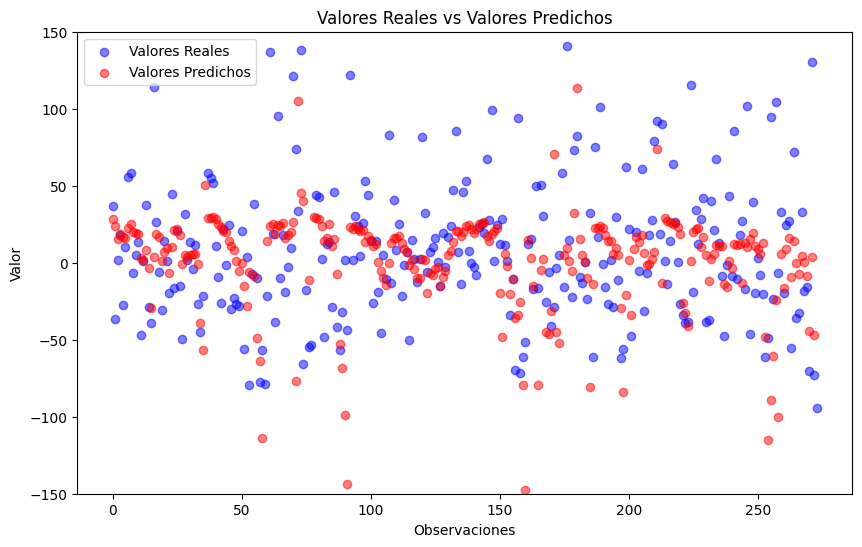

In [ ]:
y_pred_2 = results.predict(X_filtered)

# Agregar las predicciones al DataFrame filtrado
df_filtered['predicted_annual_return'] = y_pred_2

# Crear la figura
plt.figure(figsize=(10, 6))

# Graficar los valores reales
plt.scatter(range(len(y_filtered)), y_filtered, color='blue', alpha=0.5, label='Valores Reales')

# Graficar los valores predichos
plt.scatter(range(len(y_filtered)), y_pred_2, color='red', alpha=0.5, label='Valores Predichos')

# Configurar el título y las etiquetas
plt.title('Valores Reales vs Valores Predichos')
plt.xlabel('Observaciones')
plt.ylim(-150,150)
plt.ylabel('Valor')
plt.legend()

# Mostrar la figura
plt.show()


### Algebra matricial

In [ ]:
# Calcular los coeficientes beta
beta = np.linalg.inv(X.T @ X) @ X.T @ y
print("Coeficientes beta:")
print(beta)


Coeficientes beta:
0    48.800391
1   -10.919048
2    -6.321842
3     4.942111
4     2.074659
5   -44.948511
6    -6.555893
dtype: float64


In [ ]:
# Calcular la matriz de varianzas y covarianzas de los coeficientes
var_cov_matrix = np.linalg.inv(X.T @ X) * results.mse_resid
# Extraer la diagonal para obtener los errores estándar
se_beta = np.sqrt(np.diag(var_cov_matrix))
print("Errores estándar de los coeficientes:")
print(se_beta)

Errores estándar de los coeficientes:
[ 9.49364557  5.1850843  10.09526192  4.85904561  1.03227541  6.33539157
 14.56507741]


In [ ]:
# Calcular la suma de los cuadrados de las residuales (SSR)
SSR = np.sum((y - results.predict(X))**2)
# Calcular la suma de los cuadrados totales (SST)
SST = np.sum((y - np.mean(y))**2)
# Calcular R-cuadrado y R-cuadrado ajustado
R_squared = 1 - SSR / SST
adj_R_squared = 1 - (SSR / (n - k - 1)) / (SST / (n - 1))
print(f"R-cuadrado: {R_squared}")
print(f"R-cuadrado ajustado: {adj_R_squared}")


R-cuadrado: 0.24623717166439396
R-cuadrado ajustado: 0.2292986811399983


# Conclusión general
En esta conclusión, quiero destacar el proceso de mejora entre mi primer y segundo modelo, y cómo la aplicación de varios conceptos estadísticos ha permitido obtener mejores resultados en el análisis de los retornos anuales. Esta segunda iteración representa un avance significativo, no solo en términos de la precisión de las predicciones, sino también en mi comprensión de los métodos que me ayudaron a lograrlo.

En el primer modelo, encontré discrepancias notables entre los valores reales y los predichos. Los resultados me indicaban la presencia de outliers que estaban afectando la capacidad predictiva de mi modelo. Al analizar estos resultados, utilicé herramientas como *Cook's Distance* y los *studentized residuals* para identificar puntos influyentes que podrían estar distorsionando el ajuste del modelo.

### Aprendizajes y Mejora de Resultados:
El uso de los siguientes conceptos fue crucial para mejorar mi modelo:

1. **Cook's Distance**: Este método me permitió medir el impacto de cada observación en los coeficientes del modelo. Al identificar observaciones con un Cook's Distance mayor a 0.06, detecté puntos de datos que distorsionaban los resultados, como los de *Boxlight Corp*. Esto me permitió tomar decisiones informadas sobre qué observaciones eliminar.

2. **Studentized Residuals**: Los *studentized residuals* me ayudaron a evaluar el tamaño relativo de los residuos de cada observación en comparación con su error estándar. Los valores mayores a 3 indicaban posibles outliers. El uso conjunto de *Cook's Distance* y *studentized residuals* me permitió identificar con mayor precisión los puntos que debían ser eliminados.

3. **Leverage Points**: Identificar puntos de alta influencia en las variables independientes fue otro paso clave. Los *leverage points* me indicaron qué observaciones tenían valores extremos en las variables predictoras, lo que impactaba la estimación de los coeficientes del modelo.

4. **Winsorization**: Si bien en este caso decidí no usar winsorización para ajustar los valores extremos, este es un método valioso para limitar el impacto de outliers sin eliminarlos del conjunto de datos. En futuros análisis, podría considerar winsorizar en lugar de eliminar para preservar más información.

### Mejor Capacidad Predictiva:
La mejora en los resultados del modelo se reflejó en un ajuste más cercano entre los valores reales y los predichos tras eliminar los outliers identificados. Además, al aplicar el concepto de leverage, pude minimizar el impacto negativo de las observaciones extremas en los coeficientes. Estas técnicas no solo incrementaron la precisión de las predicciones, sino que también fortalecieron la robustez del modelo frente a puntos de datos atípicos.

### Importancia de la Detección de Outliers:
El proceso de detección y tratamiento de outliers mediante *Cook's Distance*, *studentized residuals* y *leverage points* fue fundamental para mejorar el rendimiento del modelo. Estos métodos me ayudaron a identificar observaciones que distorsionaban la relación entre las variables predictoras y el retorno anual, lo que, en última instancia, mejoró la capacidad del modelo para capturar la tendencia general de los datos.

### Resumen de los resultados

**Primer modelo:**
- **R-cuadrado:** 0.15, lo que indica que solo el 15% de la variabilidad en el retorno anual es explicada por las variables independientes.
- **F-statistic:** 8.15 con un valor p de 0, lo que indica que el modelo es estadísticamente significativo pero débil.
- Algunas variables no fueron significativas, como TATE, DTE, DTTNW, y DTEb, mientras que **BOOKTOMARKET** (-26, p=0) y **EPSP** (16, p=0.052) tuvieron impactos significativos.

**Segundo modelo:**
- **R-cuadrado:** 0.24, lo que indica una mejora considerable, ya que el 24% de la variabilidad es ahora explicada.
- **F-statistic:** 13.1 con un valor p de 0, mostrando una mayor solidez en la significancia global del modelo.
- Hubo mejoras en las significancias individuales. **TATE** (-10.9, p=0.036) y **DTEb** (2, p=0.046) pasaron a ser significativas, mientras que **BOOKTOMARKET** (-45, p=0) siguió mostrando un impacto fuerte.
- El modelo también mostró una mejor distribución de los residuos, como lo indica la prueba de **Jarque-Bera**.

El segundo modelo ofrece una mejora notable en la capacidad predictiva, con un ajuste mayor, más variables significativas y una mejor estructura residual.

### Reflexión personal

En conclusión, el uso de estos conceptos me permitió avanzar hacia un modelo más preciso y robusto. La experiencia de trabajar con estas herramientas y comprender su impacto en la calidad del modelo es un aprendizaje clave que puedo aplicar en futuros análisis de regresión lineal.

# Modulo 5

## 1.1 Multiple Regression - advanced topics

### 1.1.1 Calculation of Variables

In [ ]:
# Definir los límites para market_value
bins = [0, 3.942867e+05, 1.199562e+06, np.inf]
labels = ['small', 'medium', 'big']

# Asignar los tamaños de la firma según los valores de market_value
annual_data['firm_size'] = pd.cut(annual_data['MARKETVALUE'], bins=bins, labels=labels, right=False)

# Crear las variables dummy tomando como referencia la categoria "small"
annual_data['medium'] = np.where(annual_data['firm_size'] == 'medium', 1, 0)
annual_data['big'] = np.where(annual_data['firm_size'] == 'big', 1, 0)

# Imprimir el resultado para verificar
print(annual_data[['Empresa','MARKETVALUE', 'firm_size', 'yearf', 'medium', 'big']])

                          Empresa   MARKETVALUE firm_size   yearf  medium  big
0    Adtalem Global Education Inc  1.840626e+06       big  2000.0       0    1
1    Adtalem Global Education Inc  2.519168e+06       big  2001.0       0    1
2    Adtalem Global Education Inc  1.596352e+06       big  2002.0       0    1
3    Adtalem Global Education Inc  1.629265e+06       big  2003.0       0    1
4    Adtalem Global Education Inc  1.927122e+06       big  2004.0       0    1
..                            ...           ...       ...     ...     ...  ...
306                     Zovio Inc  1.902675e+05     small  2018.0       0    0
307                     Zovio Inc  6.235171e+04     small  2019.0       0    0
308                     Zovio Inc  1.525502e+05     small  2020.0       0    0
309                     Zovio Inc  4.249381e+04     small  2021.0       0    0
310                     Zovio Inc  4.891465e+03     small  2022.0       0    0

[311 rows x 6 columns]


### 1.1.2 Multiple Regression Model

#### Preprocessing stuff

In [ ]:
import statsmodels.api as sm

# Filtrar datos relevantes
df = annual_data[['Empresa','annual_return', 'TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP', 'medium', 'big']]

# Separar variables independientes y dependientes
X = df[['TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP', 'medium', 'big']]
y = df['annual_return']

# Agregar una columna de 1's para el intercepto
X = sm.add_constant(X)

# Crear el modelo de regresión OLS
model = sm.OLS(y, X, missing='drop')

# Ajustar el modelo con los datos de entrenamiento
results = model.fit()

# Filtrar el DataFrame original para mantener solo las filas usadas en el modelo
df_filtered = df.loc[used_index]

# Obtener la influencia de cada observación
influence = results.get_influence()
# Obtener el cook distance de cada observacion
cooks_distance = influence.cooks_distance


df_filtered['cooks_distance'] = cooks_distance[0]
df_filtered['is_cooks_distance'] = df_filtered['cooks_distance'] > 4/len(df_filtered)

stud_res = results.outlier_test()
df_filtered['student_resid'] = stud_res['student_resid']

# Marcar outliers
df_filtered['is_outlier'] = np.abs(df_filtered['student_resid']) > 2

# Seteamos los limites para nuestras variables independientes para evitar valores extremos
df_filtered['TATE'] = df_filtered['TATE'].clip(lower=0, upper=3.1)
df_filtered['DTE'] = df_filtered['DTE'].clip(lower=-1, upper=1.1)
df_filtered['DTTNW'] = df_filtered['DTTNW'].clip(lower=-2, upper=1.1)
df_filtered['DTEb'] = df_filtered['DTEb'].clip(lower=-3, upper=8)
df_filtered['BOOKTOMARKET'] = df_filtered['BOOKTOMARKET'].clip(lower=-1, upper=1.5)
df_filtered['EPSP'] = df_filtered['EPSP'].clip(lower=-1.5, upper=3)

df_filtered.drop(df_filtered[df_filtered['is_cooks_distance']].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['is_outlier']].index, inplace=True)

####1st Model: Company Size

In [ ]:
# Separar variables independientes y dependientes
X = df_filtered[['TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP', 'medium', 'big']]
y = df_filtered['annual_return']

# Agregar una columna de 1's para el intercepto
X = sm.add_constant(X)

# Crear el modelo de regresión OLS
model = sm.OLS(y, X, missing='drop')

# Ajustar el modelo con los datos de entrenamiento
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_return   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     9.753
Date:                Mon, 14 Oct 2024   Prob (F-statistic):           1.00e-11
Time:                        13:20:32   Log-Likelihood:                -1232.7
No. Observations:                 251   AIC:                             2483.
Df Residuals:                     242   BIC:                             2515.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           48.3222     13.381      3.611   

#### Ecuaciones de regresion para cada categoría de tamaño de empresa (firm_size)

Dado que las variables medium y big son dummies que representan las firmas de tamaño mediano y grande, respectivamente, podemos crear tres ecuaciones de regresión, una para cada grupo de tamaño. La categoría de referencia es small, y las ecuaciones para los otros dos grupos incluyen los términos dummies.

- **Para firmas pequeñas**: annual_return = 48.32 - 10.93 (TATE) - 8.94(DTE) +5.22(DTTNW) + 1.91(DTEb) - 42.48(BOOKTOMARKET) -4.4(EPSP) + ε
- **Para firmas medianas**: annual_return = (48.32 - 3.7) - 10.93 (TATE) - 8.94(DTE) +5.22(DTTNW) + 1.91(DTEb) - 42.48(BOOKTOMARKET) -4.4(EPSP) + ε
- **Para firmas pequeñas**: annual_return = (48.32 + 1.38) - 10.93 (TATE) - 8.94(DTE) +5.22(DTTNW) + 1.91(DTEb) - 42.48(BOOKTOMARKET) -4.4(EPSP) + ε

#### **Interpretación de los Coeficientes (Beta) y su Significancia Estadística**

##### **Intercepto (const)**
- **Coeficiente:** 48.32  
- **Significancia:** Valor p de 0.000, lo que lo hace altamente significativo.  
- **Interpretación:** Si todas las variables independientes fueran cero, el retorno anual esperado sería de 48.32 unidades. Aunque esto es una situación teórica, proporciona una línea base para los retornos anuales.

##### **TATE (Total Assets to Equity)**
- **Coeficiente:** -10.94  
- **Significancia:** Valor p de 0.042, lo que lo hace estadísticamente significativo.  
- **Interpretación:** Un aumento de una unidad en la relación entre activos totales y patrimonio (TATE) se asocia con una disminución de 10.94 unidades en los retornos anuales. Esto indica una relación negativa significativa entre TATE y los retornos futuros.

##### **DTE (Debt to Equity)**
- **Coeficiente:** -8.94  
- **Significancia:** Valor p de 0.379, lo que indica que no es estadísticamente significativo.  
- **Interpretación:** No hay suficiente evidencia para concluir que la relación deuda-patrimonio tenga un impacto significativo en los retornos anuales.

##### **DTTNW (Debt to Tangible Net Worth)**
- **Coeficiente:** 5.22  
- **Significancia:** Valor p de 0.290, lo que indica que no es estadísticamente significativo.  
- **Interpretación:** Aunque parece haber una correlación positiva entre DTTNW y los retornos anuales, no es lo suficientemente significativa como para sacar conclusiones definitivas.

##### **DTEb (Debt to EBITDA)**
- **Coeficiente:** 1.92  
- **Significancia:** Valor p de 0.072, lo que está cerca del umbral de significancia estadística.  
- **Interpretación:** Aunque no es completamente significativo, este coeficiente sugiere que una mayor relación deuda/EBITDA podría tener un impacto positivo leve en los retornos anuales.

##### **BOOKTOMARKET (Book-to-Market Ratio)**
- **Coeficiente:** -42.49  
- **Significancia:** Valor p de 0.000, altamente significativo.  
- **Interpretación:** Un aumento en la relación Book-to-Market se asocia con una disminución significativa de 42.49 unidades en los retornos anuales. Esto indica que empresas con mayores valores en libros en relación con el mercado tienden a tener peores retornos futuros.

##### **EPSP (Earnings per Share Price)**
- **Coeficiente:** -4.41  
- **Significancia:** Valor p de 0.767, no estadísticamente significativo.  
- **Interpretación:** No se puede concluir que haya un impacto significativo de las ganancias por acción sobre los retornos anuales.

##### **Dummy Medium (Tamaño mediano)**
- **Coeficiente:** -3.76  
- **Significancia:** Valor p de 0.629, no significativo.  
- **Interpretación:** Ser una firma mediana, en comparación con una firma pequeña, no tiene un impacto estadísticamente significativo en los retornos anuales.

##### **Dummy Big (Tamaño grande)**
- **Coeficiente:** 1.38  
- **Significancia:** Valor p de 0.847, no significativo.  
- **Interpretación:** Ser una firma grande tampoco muestra un impacto significativo en los retornos anuales en comparación con firmas pequeñas.

#### **Conclusión del Modelo**
El modelo actualizado tiene un R-cuadrado de 0.244, lo que sugiere que el 24.4% de la variabilidad en los retornos anuales es explicada por las variables independientes. Las variables TATE y BOOKTOMARKET resultan ser las más significativas. Las demás variables no muestran significancia estadística fuerte, lo que indica que sus impactos en los retornos anuales son limitados en este modelo. Las dummies para el tamaño de la empresa no son estadísticamente significativas, lo que sugiere que el tamaño de la firma no es un determinante importante de los retornos anuales en esta muestra.

#### Preproccesing stuff

In [ ]:
import statsmodels.api as sm

# Filtrar datos relevantes
df = annual_data[['Empresa','annual_return', 'TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP', 'medium', 'big', 'longdebt', 'totalassets']]

# Separar variables independientes y dependientes
X = df[['TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP', 'medium', 'big', 'longdebt', 'totalassets']]
y = df['annual_return']

# Agregar una columna de 1's para el intercepto
X = sm.add_constant(X)

# Crear el modelo de regresión OLS
model = sm.OLS(y, X, missing='drop')

# Ajustar el modelo con los datos de entrenamiento
results = model.fit()

# Filtrar el DataFrame original para mantener solo las filas usadas en el modelo
df_filtered = df.loc[used_index]

# Obtener la influencia de cada observación
influence = results.get_influence()
# Obtener el cook distance de cada observacion
cooks_distance = influence.cooks_distance


df_filtered['cooks_distance'] = cooks_distance[0]
df_filtered['is_cooks_distance'] = df_filtered['cooks_distance'] > 4/len(df_filtered)

stud_res = results.outlier_test()
df_filtered['student_resid'] = stud_res['student_resid']

# Marcar outliers
df_filtered['is_outlier'] = np.abs(df_filtered['student_resid']) > 2

# Seteamos los limites para nuestras variables independientes para evitar valores extremos
df_filtered['TATE'] = df_filtered['TATE'].clip(lower=0, upper=3.1)
df_filtered['DTE'] = df_filtered['DTE'].clip(lower=-1, upper=1.1)
df_filtered['DTTNW'] = df_filtered['DTTNW'].clip(lower=-2, upper=1.1)
df_filtered['DTEb'] = df_filtered['DTEb'].clip(lower=-3, upper=8)
df_filtered['BOOKTOMARKET'] = df_filtered['BOOKTOMARKET'].clip(lower=-1, upper=1.5)
df_filtered['EPSP'] = df_filtered['EPSP'].clip(lower=-1.5, upper=3)

df_filtered.drop(df_filtered[df_filtered['is_cooks_distance']].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['is_outlier']].index, inplace=True)

#### 2nd model: Fleverage

In [ ]:
df_filtered['fleverage'] = df_filtered['longdebt'] / df_filtered['totalassets']

# Agregar el término cuadrático de fleverage
df_filtered['fleverage_squared'] = df_filtered['fleverage'] ** 2

# Actualizar las variables independientes para incluir fleverage y su término cuadrático
X = df_filtered[['TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP', 'medium', 'big', 'fleverage', 'fleverage_squared']]
y = df_filtered[['annual_return']]
# Agregar una columna de 1's para el intercepto
X = sm.add_constant(X)

# Crear el nuevo modelo de regresión OLS
model = sm.OLS(y, X, missing='drop')

# Ajustar el modelo con los datos de entrenamiento
results = model.fit()

# Imprimir resumen de los resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     8.791
Date:                Mon, 14 Oct 2024   Prob (F-statistic):           2.88e-12
Time:                        13:20:32   Log-Likelihood:                -1226.1
No. Observations:                 251   AIC:                             2474.
Df Residuals:                     240   BIC:                             2513.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                41.8732     13.64

### Interpretación de fleverage y su término cuadrático con resultados actualizados:

1. **fleverage (coef = 155.1840, t = 2.002, p-value = 0.046)**:
   - **Coeficiente**: El coeficiente actualizado de 155.18 indica que, manteniendo constantes las demás variables, un incremento unitario en el ratio fleverage (longdebt/totalassets) se asocia con un aumento de aproximadamente 155.18 puntos en el rendimiento anual de la empresa.
   - **t-statistic**: El valor t de 2.002 indica que este coeficiente es significativo a un nivel cercano al 5%.
   - **p-value**: Con un valor p de 0.046, fleverage es estadísticamente significativo, lo que implica que hay suficiente evidencia para afirmar que el apalancamiento financiero tiene un impacto positivo en el rendimiento anual de la empresa.

2. **fleverage_squared (coef = -103.3415, t = -0.831, p-value = 0.407)**:
   - **Coeficiente**: El coeficiente negativo de -103.34 para el término cuadrático sugiere la presencia de una relación no lineal entre fleverage y el rendimiento anual. A medida que el ratio fleverage aumenta, el impacto positivo del apalancamiento sobre el rendimiento se reduce.
   - **t-statistic**: El valor t de -0.831 indica que este coeficiente no es estadísticamente significativo.
   - **p-value**: Con un p-value de 0.407, no hay evidencia suficiente para concluir que el término cuadrático de fleverage afecta significativamente el rendimiento anual.

### Conclusión:
- El coeficiente de fleverage es significativo, lo que sugiere que el apalancamiento financiero tiene un impacto positivo en el rendimiento anual.
- Sin embargo, el término cuadrático de fleverage no es significativo, lo que implica que no se ha demostrado que la relación no lineal tenga un efecto concluyente en este modelo.

#### 3rd Model: Interaction terms

In [ ]:
# Crear las interacciones entre el tamaño de la empresa y EPSP
df_filtered['medium_EPSP'] = df_filtered['medium'] * df_filtered['EPSP']
df_filtered['big_EPSP'] = df_filtered['big'] * df_filtered['EPSP']

# Crear las interacciones entre el tamaño de la empresa y BOOKTOMARKET
df_filtered['medium_BMR'] = df_filtered['medium'] * df_filtered['BOOKTOMARKET']
df_filtered['big_BMR'] = df_filtered['big'] * df_filtered['BOOKTOMARKET']

X = df_filtered[['TATE', 'DTE', 'DTTNW', 'DTEb', 'BOOKTOMARKET', 'EPSP', 'medium', 'big',
                 'fleverage', 'fleverage_squared', 'medium_EPSP', 'big_EPSP',
                 'medium_BMR', 'big_BMR']]

# La variable dependiente
y = df_filtered['annual_return']

# Agregar una constante para el intercepto
X = sm.add_constant(X)

# Crear el modelo de regresión OLS
model = sm.OLS(y, X, missing='drop')

# Ajustar el modelo
results = model.fit()

# Mostrar el resumen de los resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_return   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     7.041
Date:                Mon, 14 Oct 2024   Prob (F-statistic):           4.31e-12
Time:                        13:20:32   Log-Likelihood:                -1221.5
No. Observations:                 251   AIC:                             2473.
Df Residuals:                     236   BIC:                             2526.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                40.0757     15.83

### 1. **Ecuaciones de regresión para cada grupo de tamaño**

Para formular las ecuaciones de regresión para los grupos de tamaño (small, medium y big), tomamos en cuenta los coeficientes de las interacciones y los términos base. Las ecuaciones se diferenciarán en cómo los términos de interacción afectan cada grupo.

#### Grupo "Small" (tamaño pequeño):
Para este grupo:

annual_return = 40.07 - 9.74(TATE) - 39.53(DTE) + 3.70(DTTNW) + 0.88(DTEb) - 38.64(BOOKTOMARKET) + 10.22(EPSP) + 133.32 (fleverage) - 86.60(fleverage_squared) + ϵ

#### Grupo "Medium" (tamaño mediano):
Para este grupo, el término de interacción es medium_EPSP y medium_BMR:

annual_return = (40.07 + 14.89) - 9.74(TATE) - 39.53(DTE) + 3.70(DTTNW) + 0.88(DTEb) - 38.64(BOOKTOMARKET) + 10.22(EPSP) + 133.32 (fleverage) - 86.60(fleverage_squared)  - 129.82(EPSP_medium) - 24.44(BOOKTOMARKET_medium) + ϵ

#### Grupo "Big" (tamaño grande):
Para este grupo, el término de interacción es big_EPSP y big_BMR:

annual_return = (40.07 + 0.92) - 9.74(TATE) - 39.53(DTE) + 3.70(DTTNW) + 0.88(DTEb) - 38.64(BOOKTOMARKET) + 10.22(EPSP) + 133.32 (fleverage) - 86.60(fleverage_squared)  - 5.09(EPSP_big) - 2.01(BOOKTOMARKET_big) + ϵ

### 2. **Interpretación de los coeficientes de interacción**

-**medium_EPSP** (-129.8289, p = 0.012): El coeficiente negativo y significativo indica que para empresas de tamaño mediano, un aumento en el EPSP está relacionado con una disminución considerable en los retornos anuales.

-**big_EPSP** (5.0982, p = 0.932): Este coeficiente no es significativo, lo que sugiere que para las empresas grandes, el EPSP no tiene un efecto relevante en los retornos.

-**medium_BMR** (-24.4432, p = 0.157): Aunque no es significativo, hay una tendencia negativa que sugiere que el ratio BOOKTOMARKET podría estar relacionado con menores retornos en empresas medianas.

-**big_BMR** (2.0166, p = 0.895): Este coeficiente tampoco es significativo, lo que indica que el ratio BOOKTOMARKET no parece afectar los retornos en empresas grandes.

### 3. **¿Mejoró el R-cuadrado?**

El modelo mejoró en términos de ajuste (R-cuadrado de 0.295 frente a versiones previas) y algunos coeficientes resultan significativos, como BOOKTOMARKET y la interacción medium_EPSP. Sin embargo, las interacciones en empresas grandes (big_EPSP y big_BMR) no son significativas, lo que indica que el tamaño de las empresas medianas juega un rol más relevante en la relación entre las variables y los retornos.

### Conclusión:
Los términos de interacción agregaron una mejor explicación en las empresas medianas para el **BOOKTOMARKET**, aunque los términos relacionados con **EPSP** no resultaron significativos. El modelo mejoró ligeramente en términos de R-cuadrado, lo que sugiere que incluir las interacciones añade valor al análisis.

#### How can you use these results to select 10 promising stocks with high probability to offer attractive returns?

Para seleccionar 10 acciones prometedoras con alta probabilidad de ofrecer rendimientos atractivos, es crucial basarnos en los resultados de la regresión múltiple y la interpretación de las variables que muestran mayor influencia en el rendimiento anual (**annual_return**).

### Lógica de Selección:
A partir del modelo de regresión, las variables significativas (p-valor < 0.05) y sus coeficientes nos indican los factores que impactan más en los rendimientos:

1. **Tamaño de las empresas (medium y big)**:
   - **medium** tiene un coeficiente positivo significativo (+28.5120, p=0.014), lo que sugiere que las empresas medianas tienden a ofrecer mayores rendimientos anuales.
   - **BOOKTOMARKET** para empresas medianas es significativo y negativo, lo que significa que una menor relación libro/mercado en este grupo puede predecir buenos retornos.

2. **Interacción EPSP para medianas**:
   - Aunque **EPSP** (Earnings per Share Performance) no es significativo en general, para empresas medianas, la interacción **medium_EPSP** (-89.9064, p=0.069) sugiere que los valores altos de EPSP pueden no ser tan beneficiosos en este grupo, pero esto es marginalmente significativo.

### Estrategia:
- **Enfocarse en empresas medianas**, ya que su coeficiente positivo es notable y significativo.
- **Seleccionar empresas con menores valores de BOOKTOMARKET**, especialmente en el grupo de empresas medianas.
- **EPSP y otros ratios financieros**: Buscar empresas con ratios que muestren estabilidad financiera (fleverage, DTTNW, etc.), aunque algunos no sean tan significativos.

In [ ]:
# Criterio 1: Empresas medianas (variable 'medium' = 1)
medium_stocks = df_filtered[df_filtered['medium'] == 1]

# Criterio 2: Seleccionar empresas con bajo Book-to-Market ratio
medium_stocks_sorted = medium_stocks.sort_values(by='BOOKTOMARKET')

# Criterio 3: Seleccionar las 10 primeras acciones
top_10_stocks = medium_stocks_sorted.head(10)

# Mostrar los resultados
top_10_stocks[['Empresa', 'annual_return', 'BOOKTOMARKET', 'EPSP', 'medium']]


,Empresa,annual_return,BOOKTOMARKET,EPSP,medium
244,"Strategic Education, Inc",92.028264,-0.165562,0.056051,1
245,"Strategic Education, Inc",18.603753,0.013274,0.053687,1
246,"Strategic Education, Inc",89.985008,0.028226,0.028821,1
254,"Strategic Education, Inc",-33.741224,0.036248,0.090888,1
255,"Strategic Education, Inc",-38.879312,0.061459,0.098858,1
164,ITT Educational Services Inc,27.746135,0.083178,0.040974,1
163,ITT Educational Services Inc,67.590909,0.089646,0.038655,1
175,ITT Educational Services Inc,93.991912,0.147100,-0.034374,1
72,Capella Education Co,17.785652,0.197525,0.022266,1
70,Capella Education Co,94.998293,0.206912,0.042684,1


## Part 2 - Forecasting the IGAE index for Mexico

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
file_path = '/content/conjunto_de_datos_igae_igae2024_07.csv'
df = pd.read_csv(file_path)

df

,Descriptores,1993|Enero,1993|Febrero,1993|Marzo,1993|Abril,1993|Mayo,1993|Junio,1993|Julio,1993|Agosto,1993|Septiembre,...,2024|Abril<P>,2024|Mayo<P>,2024|Junio<R>,2024|Julio<P>,2024|Agosto,2024|Septiembre,2024|Octubre,2024|Noviembre,2024|Diciembre,2024|Anual
0,Índice de volumen físico base 2018=100|Total,55.434736,56.456971,58.900549,57.135844,57.891853,57.475466,57.902380,57.123934,58.482049,...,105.761270,107.868081,104.049350,106.727192,NaN,NaN,NaN,NaN,NaN,NaN
1,Índice de volumen físico base 2018=100|Activid...,58.796198,60.763816,55.964953,58.989164,61.762078,63.641132,72.628654,57.488221,54.105257,...,93.616458,115.737397,109.980834,114.238830,NaN,NaN,NaN,NaN,NaN,NaN
2,Índice de volumen físico base 2018=100|Activid...,54.888804,56.855371,50.409267,52.261002,55.582213,57.282877,68.319936,42.898071,38.338437,...,85.964795,117.459113,108.212905,112.856003,NaN,NaN,NaN,NaN,NaN,NaN
3,Índice de volumen físico base 2018=100|Activid...,67.248422,68.977815,67.346044,73.409111,75.161246,77.687091,81.891772,88.914213,88.045743,...,110.293170,112.483585,114.229715,117.483418,NaN,NaN,NaN,NaN,NaN,NaN
4,Índice de volumen físico base 2018=100|Activid...,63.307782,64.889130,68.070475,64.524614,64.382808,62.471146,64.791953,66.301834,67.703709,...,106.098672,107.052347,103.535412,106.218555,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Variación porcentual anual de los índices acum...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.967461,4.047763,3.829141,3.645878,NaN,NaN,NaN,NaN,NaN,NaN
116,Variación porcentual anual de los índices acum...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.619019,-11.871901,-7.385158,-6.248585,NaN,NaN,NaN,NaN,NaN,NaN
117,Variación porcentual anual de los índices acum...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.015588,-1.555244,-1.471593,-1.892279,NaN,NaN,NaN,NaN,NaN,NaN
118,Variación porcentual anual de los índices acum...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.827775,3.474305,3.215729,3.238871,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.melt(id_vars=["Descriptores"], var_name="Fechas", value_name="Valor")

# Mostramos las primeras filas del nuevo DataFrame
df.head()

,Descriptores,Fechas,Valor
0,Índice de volumen físico base 2018=100|Total,1993|Enero,55.434736
1,Índice de volumen físico base 2018=100|Activid...,1993|Enero,58.796198
2,Índice de volumen físico base 2018=100|Activid...,1993|Enero,54.888804
3,Índice de volumen físico base 2018=100|Activid...,1993|Enero,67.248422
4,Índice de volumen físico base 2018=100|Activid...,1993|Enero,63.307782


<ipython-input-20-8ef6cc1e8bdb>:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie_log = serie_log.resample('M').last()


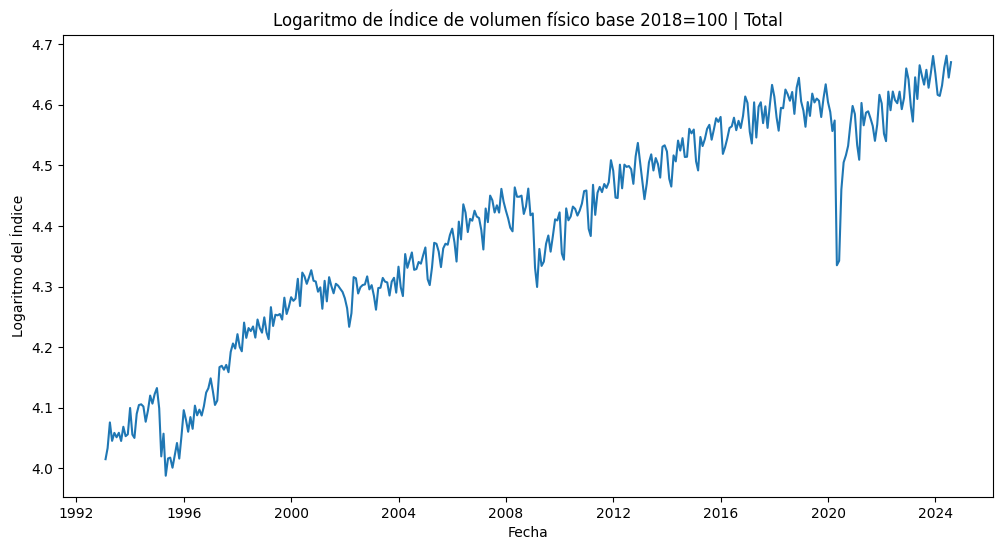

Estadística ADF: -1.219482
p-value: 0.665159


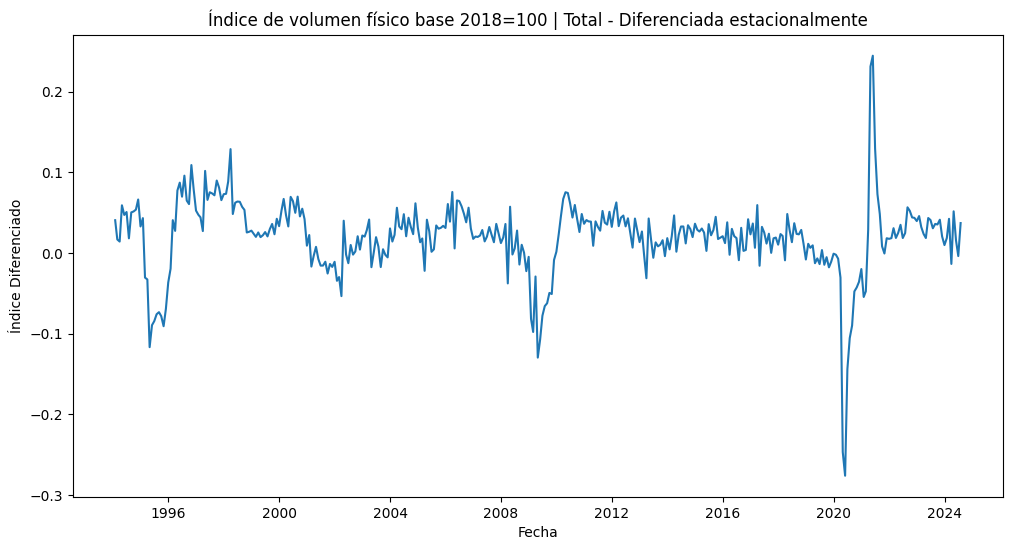

Estadística ADF: -4.506036
p-value: 0.000192


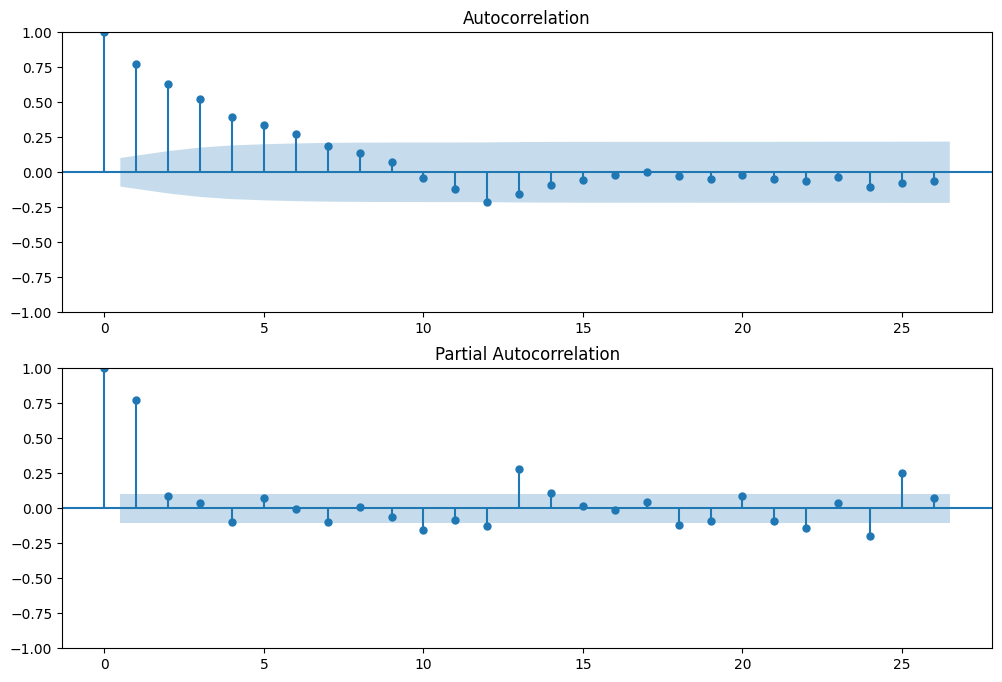

In [ ]:
import re

# Filtrar por el descriptor "Índice de volumen físico base 2018=100|Total"
df_filtered = df[df["Descriptores"] == "Índice de volumen físico base 2018=100|Total"]

# Eliminar registros con fechas que contengan "Anual"
df_filtered = df_filtered[~df_filtered["Fechas"].str.contains("Anual")]

# Diccionario para convertir los meses en español a números
meses_dict = {
    "Enero": "01", "Febrero": "02", "Marzo": "03", "Abril": "04",
    "Mayo": "05", "Junio": "06", "Julio": "07", "Agosto": "08",
    "Septiembre": "09", "Octubre": "10", "Noviembre": "11", "Diciembre": "12"
}

# Función para convertir el formato "YYYY|Mes" o "YYYY|Mes<letras>" a "YYYY-MM-01"
def convertir_fecha(fecha):
    # Extraer el año y el mes usando una expresión regular
    match = re.match(r"(\d{4})\|([A-Za-z]+)", fecha)
    if match:
        year = match.group(1)
        mes = match.group(2)
        # Convertir el mes a número usando el diccionario
        mes_num = meses_dict.get(mes, "01")  # Si no encuentra el mes, asigna enero (01)
        # Retornar la fecha en formato "YYYY-MM-01"
        return f"{year}-{mes_num}-01"
    return None  # Si no coincide el formato, retornar None

# Aplicar la función de conversión a la columna "Fechas"
df_filtered["Fechas"] = df_filtered["Fechas"].apply(convertir_fecha)

# Convertir la columna 'Fechas' a tipo datetime
df_filtered["Fechas"] = pd.to_datetime(df_filtered["Fechas"], format="%Y-%m-%d")

# Eliminar valores NaN en la columna 'Valor' y convertirla a tipo float
df_filtered = df_filtered.dropna(subset=["Valor"])

df_filtered["Valor"] = df_filtered["Valor"].astype(float)

# Seleccionar la columna de 'Valor' y establecer 'Fechas' como índice
serie = df_filtered.set_index("Fechas")["Valor"]

# Aplicar logaritmos a la serie
serie_log = np.log(serie)

# Convertir a serie de tiempo mensual (resampleando al final de cada mes)
serie_log = serie_log.resample('M').last()

# Eliminar valores NaN si los hay
serie_log = serie_log.dropna()

# Visualizar la serie con logaritmos
plt.figure(figsize=(12,6))
plt.plot(serie_log)
plt.title('Logaritmo de Índice de volumen físico base 2018=100 | Total')
plt.xlabel('Fecha')
plt.ylabel('Logaritmo del Índice')
plt.show()
result = adfuller(serie_log.dropna(), maxlag=12)
print('Estadística ADF: %f' % result[0])
print('p-value: %f' % result[1])

# Diferenciar la serie logarítmica estacionalmente (diferencia anual)
serie_diff = serie_log.diff(12).dropna()

# Visualizar la serie diferenciada
plt.figure(figsize=(12,6))
plt.plot(serie_diff)
plt.title('Índice de volumen físico base 2018=100 | Total - Diferenciada estacionalmente')
plt.xlabel('Fecha')
plt.ylabel('Índice Diferenciado')
plt.show()

# Prueba de estacionariedad en la serie diferenciada
result = adfuller(serie_diff.dropna(), maxlag=12)
print('Estadística ADF: %f' % result[0])
print('p-value: %f' % result[1])

# Gráficos ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(serie_diff, ax=ax1)
plot_pacf(serie_diff, ax=ax2)
plt.show()

### Procesamiento y Calibración de Datos del IGAE

#### 1. Preparación Inicial de los Datos

- Se utilizó la función melt() para reestructurar el DataFrame, convirtiendo las columnas de fechas en filas.
- Se filtró el DataFrame para incluir solo el "Índice de volumen físico base 2018=100|Total".
- Se eliminaron los registros con fechas anuales para mantener solo datos mensuales.

#### 2. Limpieza y Formateo de Fechas

- Se creó un diccionario para convertir los nombres de los meses en español a números.
- Se implementó una función convertir_fecha() para transformar el formato de fecha de "YYYY|Mes" a "YYYY-MM-01".
- Se aplicó esta función a la columna "Fechas" y se convirtió a tipo datetime.

#### 3. Limpieza y Conversión de Valores

- Se eliminaron los valores NaN de la columna 'Valor'.
- Se convirtió la columna 'Valor' a tipo float para facilitar los cálculos numéricos.

#### 4. Creación de la Serie Temporal

- Se seleccionó la columna 'Valor' y se estableció 'Fechas' como índice.
- Se aplicó una transformación logarítmica a la serie para estabilizar la varianza.
- Se resampleó la serie a frecuencia mensual, tomando el último valor de cada mes.
- Se eliminaron valores NaN resultantes del resampleo.

#### 5. Visualización y Análisis Inicial

- Se graficó la serie logarítmica para observar su comportamiento general.
- Se realizó una prueba de Dickey-Fuller Aumentada (ADF) para evaluar la estacionariedad de la serie logarítmica.

#### 6. Diferenciación Estacional

- Se aplicó una diferenciación estacional (anual) a la serie logarítmica.
- Se visualizó la serie diferenciada para observar la eliminación de tendencias y patrones estacionales.
- Se realizó otra prueba ADF en la serie diferenciada para confirmar la estacionariedad.

###### 7. Análisis de Autocorrelación

- Se generaron gráficos de Función de Autocorrelación (ACF) y Función de Autocorrelación Parcial (PACF).
- Estos gráficos se utilizaron para identificar patrones y ayudar en la selección de los órdenes del modelo SARIMA.

Este proceso de preparación y análisis de datos es fundamental para asegurar que la serie temporal esté adecuadamente procesada y sea apropiada para el modelado SARIMA(X) subsiguiente. La transformación logarítmica y la diferenciación estacional son pasos clave para lograr la estacionariedad, mientras que los análisis de ACF y PACF proporcionan información valiosa para la especificación del modelo.

                                     SARIMAX Results                                      
Dep. Variable:                              Valor   No. Observations:                  379
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 788.986
Date:                            Tue, 22 Oct 2024   AIC                          -1569.973
Time:                                    01:02:47   BIC                          -1554.351
Sample:                                01-31-1993   HQIC                         -1563.766
                                     - 07-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7033      0.029     23.917      0.000       0.646       0.761
ar.L2          0.1624      0.036   

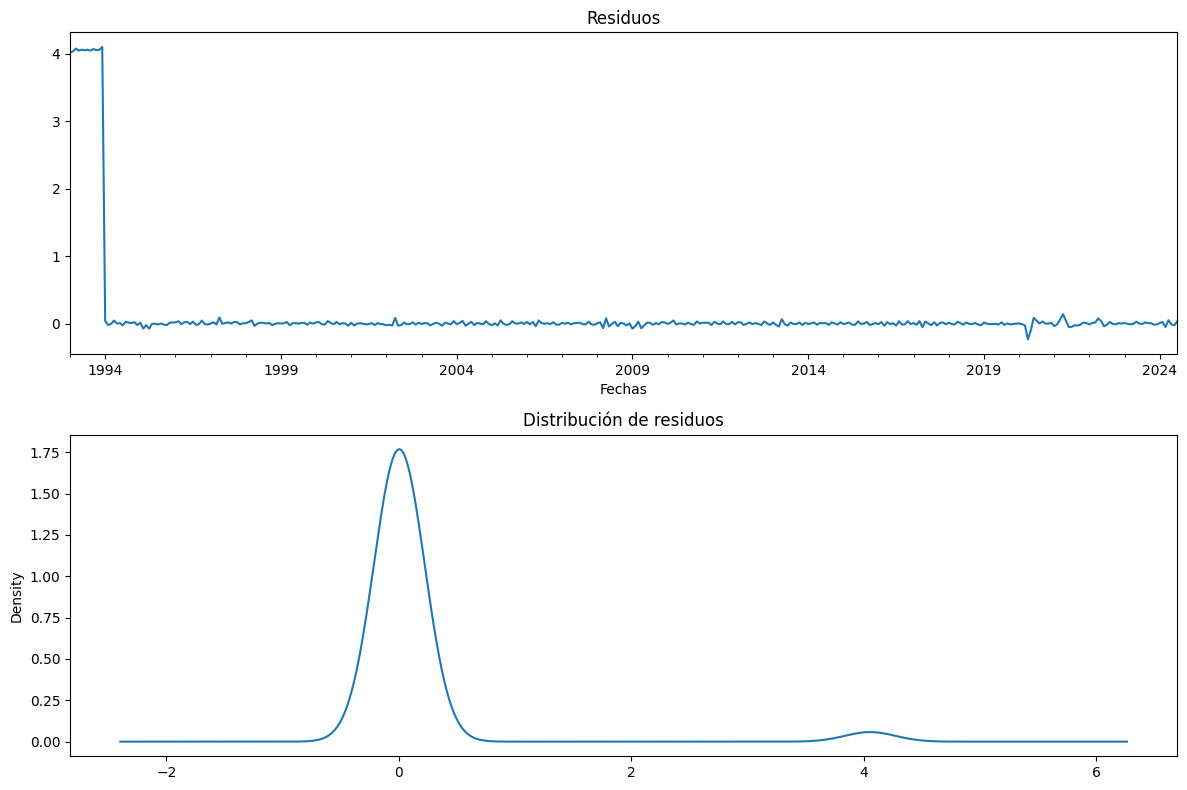

        lb_stat      lb_pvalue
1    320.399389   1.185511e-71
2    585.795655  6.253019e-128
3    801.156958  2.428382e-173
4    972.023272  4.124466e-209
5   1103.331009  2.539647e-236
6   1200.167945  4.402340e-256
7   1267.330973  1.938045e-269
8   1310.654949  1.169789e-277
9   1335.165717  7.849675e-282
10  1346.048325  4.403687e-283
11  1348.851184  1.302976e-282
12  1348.851274  1.477010e-281


In [ ]:
# Implementación del modelo SARIMA con parámetros estimados
model = SARIMAX(serie_log, order=(2,0,0), seasonal_order=(1,1,0,12))
results = model.fit()

# Mostrar el resumen del modelo ajustado
print(results.summary())

# Diagnóstico de residuos
residuos = results.resid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
residuos.plot(title="Residuos", ax=ax1)
residuos.plot(kind='kde', title="Distribución de residuos", ax=ax2)
plt.tight_layout()
plt.show()

# Test de Ljung-Box para verificar si los residuos son ruido blanco
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(residuos, lags=12, return_df=True)
print(lb_result)

### Explicación de parámetros
- p: Se encontró que antes del drop brusco en el PACF habían dos rezagos, por lo tanto, este valor es igual a 2.
- d: No se aplicó una diferenciación mensual, por lo tanto, este valor es 0.
- q: No se encontró ningún drop drástico/brusco en el ACF en un periodo mensual, por lo tanto, el valor es 0.
- P: Se encontró en el PACF que al inicio de cada año hay un rezago mucho más alto que los demás rezagos, por lo tanto, este valor es 1.
- D: Se aplicó una diferencia anual para volverle estacionario, por lo tanto, este valor es 1.
- Q: No se encontró ningún drop drástico/brusco en el ACF en un periodo anual, por lo tanto, el valor es 0.
- s: Como tenemos datos mensuales y la diferenciación es anual, el valor de esta s es igual a 12.

In [ ]:
# Crear la variable exógena "crisis"
crisis = pd.Series(0, index=serie_log.index)
crisis.loc['1994-01-01':'1996-06-30'] = 1
crisis.loc['2008-01-01':'2010-01-01'] = 1
crisis.loc['2020-01-01':'2021-08-31'] = 1

                                     SARIMAX Results                                      
Dep. Variable:                              Valor   No. Observations:                  379
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 789.086
Date:                            Tue, 22 Oct 2024   AIC                          -1568.173
Time:                                    01:02:51   BIC                          -1548.646
Sample:                                01-31-1993   HQIC                         -1560.414
                                     - 07-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0042      0.011      0.375      0.707      -0.018       0.026
ar.L1          0.7039      0.030   

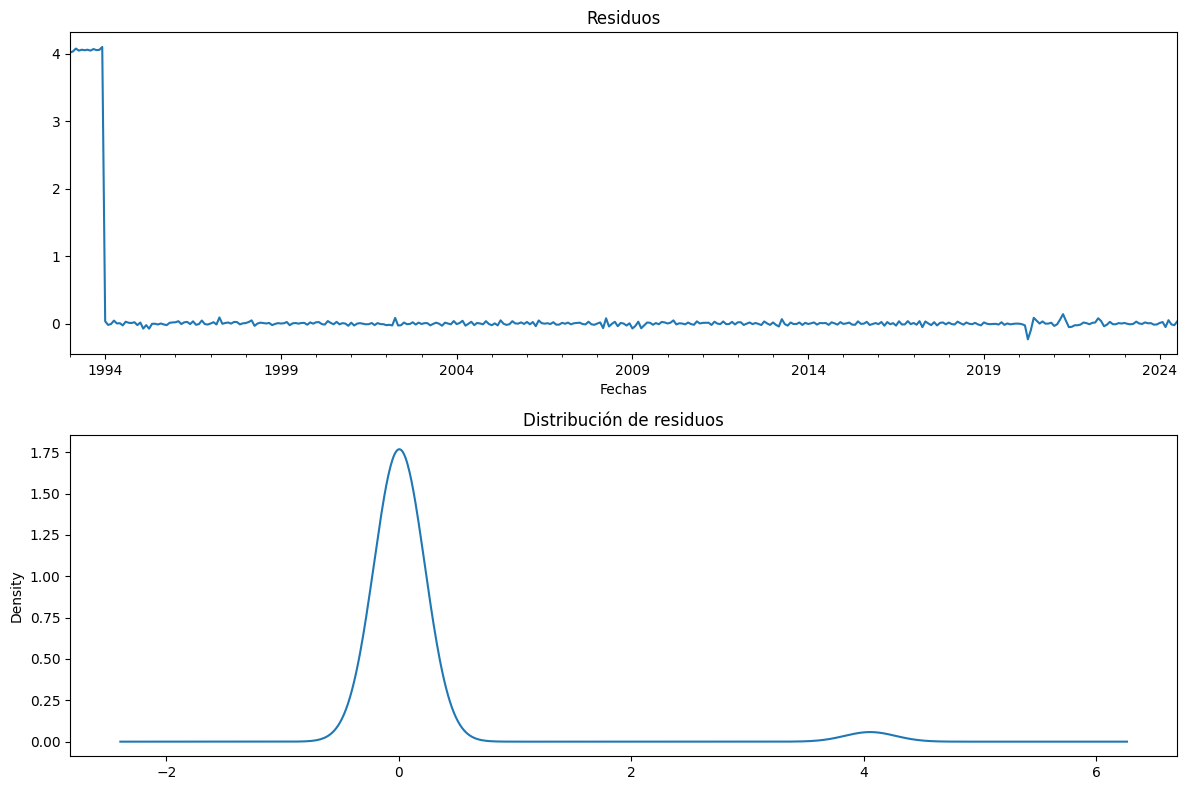

        lb_stat      lb_pvalue
1    320.340203   1.221231e-71
2    585.673678  6.646249e-128
3    800.968933  2.667443e-173
4    971.769684  4.680804e-209
5   1103.012283  2.977117e-236
6   1199.787443  5.321495e-256
7   1266.894009  2.409215e-269
8   1310.166078  1.492036e-277
9   1334.634838  1.022179e-281
10  1345.486766  5.821483e-283
11  1348.272560  1.736784e-282
12  1348.272575  1.968411e-281


In [ ]:
# Implementación del modelo SARIMAX con la variable exógena "crisis"
model = SARIMAX(serie_log, order=(2,0,0), seasonal_order=(1,1,0,12), exog=crisis)
results = model.fit()

# Mostrar el resumen del modelo ajustado
print(results.summary())

# Diagnóstico de residuos
residuos = results.resid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
residuos.plot(title="Residuos", ax=ax1)
residuos.plot(kind='kde', title="Distribución de residuos", ax=ax2)
plt.tight_layout()
plt.show()

# Test de Ljung-Box para verificar si los residuos son ruido blanco
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(residuos, lags=12, return_df=True)
print(lb_result)

### Coeficientes autoregresivos (AR):

**AR(1) o ar.L1**:
- En el primer modelo, el coeficiente es **0.7033**, con un p-valor de **0.000**, lo que indica que es estadísticamente significativo al nivel de 0.05. Esto sugiere que si el valor del índice aumenta en un mes, es probable que aumente también en el siguiente, dado que el coeficiente es positivo.
- En el segundo modelo, el coeficiente es **0.7039**, con un p-valor de **0.000**, manteniendo la significancia estadística y reforzando la relación positiva entre el valor del índice de un mes al siguiente.

**AR(2) o ar.L2**:
- En el primer modelo, el coeficiente es **0.1624**, con un p-valor de **0.000**, lo que indica significancia estadística. Esto sugiere una relación positiva entre el valor del índice en el mes actual y dos meses atrás.
- En el segundo modelo, el coeficiente es **0.1659**, con un p-valor de **0.000**, lo que también lo hace significativo, manteniendo la relación positiva entre el índice de dos meses anteriores y el actual.

### Componente estacional:
El modelo incluye un componente estacional (1,1,0,12), lo que significa que se está aplicando una diferenciación estacional de orden 1 con un período de 12 meses.

- En el primer modelo, el coeficiente del término estacional **(ar.S.L12)** es **-0.3394**, con un p-valor de **0.000**, indicando un fuerte efecto estacional anual. Este coeficiente negativo sugiere una relación inversa con respecto a los valores de hace un año.
- En el segundo modelo, el coeficiente del término estacional **(ar.S.L12)** es **-0.3392**, con un p-valor de **0.000**, manteniendo la significancia y el efecto estacional inverso.

### Variable exógena:
En el segundo modelo, se incluye una variable exógena con un coeficiente de **0.0042**, pero su p-valor es **0.707**, lo que indica que no es estadísticamente significativa al nivel de 0.05. Esto sugiere que no hay evidencia suficiente para afirmar que esta variable exógena tiene un impacto significativo en la serie temporal modelada.

### Diagnóstico del modelo:

**AIC (Criterio de Información de Akaike)**:
- En el primer modelo, el AIC es **-1569.973**, lo que sugiere un buen ajuste.
- En el segundo modelo, el AIC es **-1568.173**, ligeramente superior al del primer modelo, lo que indica que la inclusión de la variable exógena no mejora el ajuste del modelo.

**Prueba de Ljung-Box**:
- En ambos modelos, los p-valores de la prueba Ljung-Box para el rezago 1 son superiores a 0.05 (**0.52** y **0.53**, respectivamente), lo que sugiere que no hay autocorrelación significativa en los residuos hasta ese punto.

**Prueba de Jarque-Bera**:
- En el primer modelo, el p-valor de la prueba de Jarque-Bera es **0.00**, lo que indica que los residuos no siguen una distribución normal. Los valores de asimetría (**-1.23**) y curtosis (**18.27**) sugieren colas largas y un pico elevado.
- En el segundo modelo, los resultados son similares, con un p-valor de **0.00**, una asimetría de **-1.23** y una curtosis de **18.37**, manteniendo la no normalidad de los residuos.

**Prueba de heterocedasticidad**:
- En ambos modelos, el p-valor es **0.00**, lo que indica que la varianza de los residuos no es constante a lo largo del tiempo, lo que puede afectar la precisión de las predicciones.

### Comparación entre modelos:
- **Primer modelo (sin exógena)**:
  - **Log Likelihood**: **788.986**
  - **AIC**: **-1569.973**

- **Segundo modelo (con exógena)**:
  - **Log Likelihood**: **789.086**
  - **AIC**: **-1568.173**

Aunque el segundo modelo presenta un Log Likelihood ligeramente mayor, el **AIC** es mejor en el primer modelo. Esto refuerza la conclusión de que la inclusión de la variable exógena no mejora significativamente el ajuste del modelo, lo cual está alineado con el p-valor alto del coeficiente de la variable exógena.

### Conclusión

El modelo SARIMAX ajustado sigue mostrando una captura efectiva de algunos de los componentes clave de la serie temporal, pero también revela ciertas limitaciones que vale la pena resaltar. Los principales hallazgos son los siguientes:

1. **Coeficientes Autoregresivos (AR):**
   - **AR(1)**: En el primer modelo, el coeficiente es de **0.7033**, con un p-valor de **0.000**, lo que lo hace altamente significativo. Esto indica una fuerte influencia positiva del valor del mes anterior sobre el valor actual, es decir, un incremento en un mes tiende a estar seguido por otro incremento.
   - **AR(2)**: El coeficiente del segundo rezago es de **0.1624**, también con un p-valor de **0.000**, lo que refuerza su significancia. Este valor positivo implica una influencia más moderada de los valores dos meses atrás, lo que sugiere que las dinámicas autoregresivas tienen un impacto sostenido, aunque decreciente, en los valores de la serie temporal.

2. **Componente estacional:**
   - **AR Estacional (L12)**: El coeficiente del componente estacional es de **-0.3394** en el primer modelo y **-0.3392** en el segundo, ambos con un p-valor de **0.000**, indicando una fuerte significancia. Este coeficiente negativo sugiere que los valores de hace 12 meses tienen una relación inversa con los valores actuales. Sin embargo, la **prueba de Ljung-Box** muestra que sigue habiendo autocorrelación en el rezago 12, lo que sugiere que la estacionalidad no se ha capturado completamente, a pesar de la inclusión del componente estacional.

3. **Variable exógena "crisis":**
   - En el segundo modelo que incluye la variable exógena, el coeficiente para la "crisis" es **0.0042**, con un p-valor de **0.707**, lo que lo hace insignificante. Este resultado refuerza la idea de que la variable "crisis" no tiene un impacto significativo en la serie temporal, y su inclusión no mejora sustancialmente el modelo. Esto se refleja también en los valores de AIC, donde el modelo sin crisis tiene un AIC de **-1569.973**, comparado con **-1568.173** del modelo con crisis, lo que indica que la adición de esta variable no mejora el ajuste del modelo.

4. **Diagnóstico del modelo:**
   - El **AIC** de ambos modelos es bajo, lo que indica un buen ajuste general, con un ligero mejor desempeño del modelo sin la variable exógena.
   - La **prueba de Ljung-Box** sugiere que, a excepción del rezago 12, los residuos no muestran autocorrelación significativa en rezagos anteriores, lo que confirma que el modelo captura correctamente la dinámica de corto plazo.
   - La **prueba de Jarque-Bera** revela que los residuos no siguen una distribución normal, con una asimetría negativa de **-1.23** y una curtosis elevada (**18.27** y **18.37** en ambos modelos), lo que indica colas pesadas y una concentración más alta en torno a la media, afectando potencialmente la precisión de las predicciones y la fiabilidad de los intervalos de confianza.
   - **Heterocedasticidad**: La prueba indica variabilidad no constante en los residuos a lo largo del tiempo, lo que podría reflejar subestimaciones o sobreestimaciones en ciertos periodos.

5. **Comparación entre modelos:**
   - La inclusión de la variable exógena "crisis" no mejora significativamente el ajuste del modelo, como lo demuestra la mínima diferencia en el AIC entre ambos modelos, y el coeficiente de crisis resulta ser insignificante. En consecuencia, la variable exógena no aporta un valor predictivo adicional a la serie.

### Conclusión general:
El modelo SARIMAX captura bien las dinámicas de corto plazo mediante los términos autoregresivos y parcialmente la estacionalidad anual. Sin embargo, la estructura estacional no se ajusta completamente, como lo demuestra la autocorrelación en el rezago 12. Además, los residuos presentan problemas de normalidad y heterocedasticidad. La variable exógena "crisis" no aporta mejoras significativas al modelo, lo que sugiere que su influencia en la serie temporal es limitada o inexistente.

In [ ]:
# Crear un rango de fechas hasta 2030
future_dates = pd.date_range(start=serie_log.index[-1] + pd.DateOffset(months=1), end='2030-12-31', freq='M')

# Extender la variable crisis hasta 2030 (asumiendo que no hay crisis futuras conocidas)
future_crisis = pd.Series(0, index=future_dates)

# Combinar la crisis original con la futura
crisis_extended = pd.concat([crisis, future_crisis])

<ipython-input-24-c7c3acd6a740>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=serie_log.index[-1] + pd.DateOffset(months=1), end='2030-12-31', freq='M')


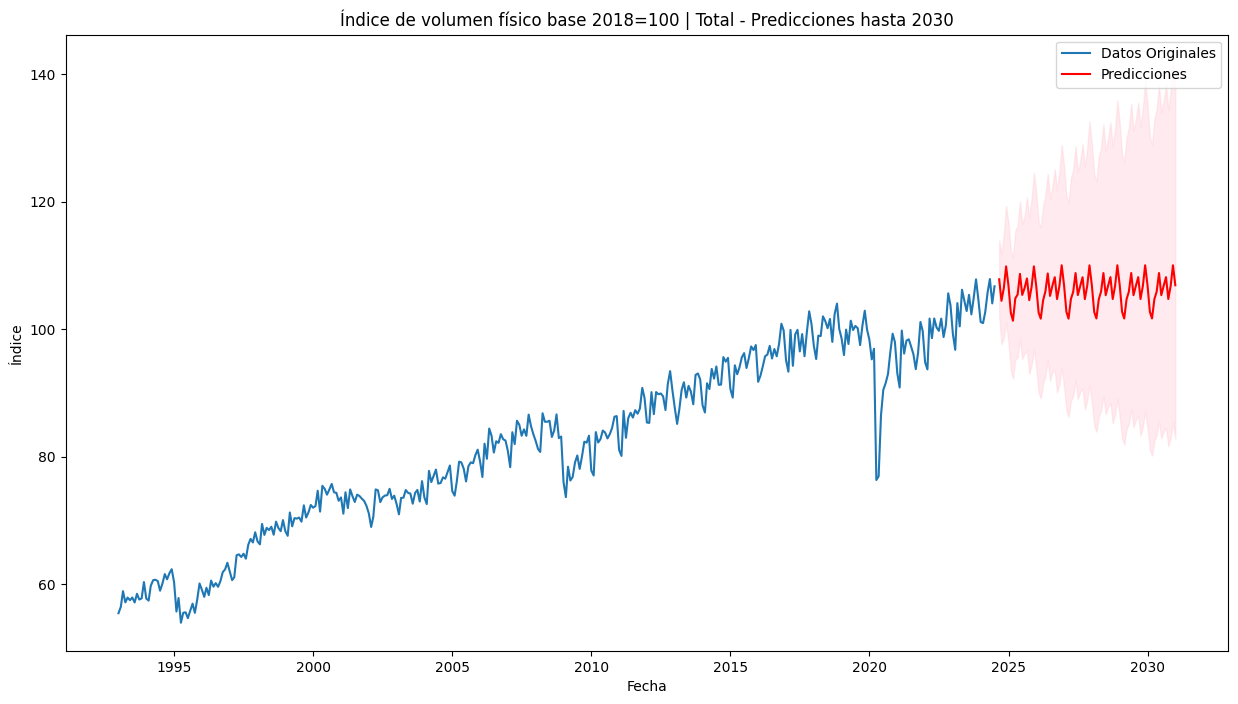

In [ ]:
# Hacer predicciones
forecast = results.get_forecast(steps=len(future_dates), exog=future_crisis)

# Obtener los valores pronosticados y los intervalos de confianza
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# Convertir las predicciones de logaritmos a valores originales
pred_mean_original = np.exp(pred_mean)
pred_ci_original = np.exp(pred_ci)

# Crear un gráfico con los datos originales y las predicciones
plt.figure(figsize=(15, 8))

# Datos originales
plt.plot(serie, label='Datos Originales')

# Predicciones
plt.plot(pred_mean_original, color='red', label='Predicciones')

# Intervalos de confianza
plt.fill_between(pred_ci_original.index,
                 pred_ci_original.iloc[:, 0],
                 pred_ci_original.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Índice de volumen físico base 2018=100 | Total - Predicciones hasta 2030')
plt.xlabel('Fecha')
plt.ylabel('Índice')
plt.legend()
plt.show()